### DoRothEA VS CollecTRI

&emsp;&emsp;&emsp;



<br></br>

### **Data Preparation**

In [ ]:
# Install necessary libraries
%pip install scanpy
%pip install decoupler
%pip install pydeseq2
%pip install adjustText
%pip install omnipath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=f67d6d39cb73591b17a59fe6566316e24128114c431647ffc9767be426896211
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=bc2e732962356699909c76895b585d588aa2f25e3928a699cc7e545cda077a93
  Stored in directory: /root/.cache/pip/wheels/6a/a

In [ ]:
# Import Necessary libraries
import scanpy as sc
import decoupler as dc
import omnipath as op

# Data Manipulation
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy import stats

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Differential Expression Analysis (DESeq2)
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import warnings
warnings.filterwarnings("ignore")

import os
os.mkdir("/content/datasets")

In [ ]:
# Retrieve CollecTRI gene regulatory network
try:
    collectri = dc.get_collectri(organism='human', split_complexes=False)
    collectri.to_csv("datasets/collectri.csv",index=False)
except:
    collectri = pd.read_table("datasets/collectri.csv", sep=',')
collectri

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

In [ ]:
# Retrieve DoRothEA gene regulatory network
try:
    dorothea = dc.get_dorothea(organism='human')
    dorothea.to_csv("datasets/dorothea.csv",index=False)
except:
    dorothea = pd.read_table("datasets/dorothea.csv", sep=',')
dorothea

0.00B [00:00, ?B/s]

source confidence  target    weight
0        MYC          A    TERT  1.000000
1        FOS          A     NTS  1.000000
2        FOS          A    NTF3  1.000000
3        FOS          A   NFKB1 -1.000000
4        FOS          A    NEFL  1.000000
...      ...        ...     ...       ...
32270   LEF1          C    NKD1  0.333333
32271   LEF1          C   NETO2  0.333333
32272   LEF1          C  MYO18B  0.333333
32273   LEF1          C  PHLDB2  0.333333
32274  ZNF83          C  ZNF331  0.333333

[32275 rows x 4 columns]

In [ ]:
# Download the data from GEO
try:
    !wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
    !gzip -d -f counts.txt.gz
    !mv counts.txt datasets/counts.txt
except:
    print("Error! Please upload counts.txt file manually.")

# Read raw data and process it
adata_table = pd.read_csv('datasets/counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata_table

--2023-09-15 01:00:06--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1.5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1.50M  3.98MB/s    in 0.4s    

2023-09-15 01:00:07 (3.98 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]



GeneName       DDX11L1  WASH7P  MIR6859-1  MIR1302-11  MIR1302-9  FAM138A  \
25_HSCs-Ctrl1        0       9         10           1          0        0   
26_HSCs-Ctrl2        0      12         14           0          0        0   
27_HSCs-Ctrl3        0      14         10           0          0        0   
31_HSCs-TGFb1        0      11         16           0          0        0   
32_HSCs-TGFb2        0       5          8           0          0        0   
33_HSCs-TGFb3        0      12          5           0          0        0   

GeneName       OR4G4P  OR4G11P  OR4F5  RP11-34P13.7  ...  MT-ND4  MT-TH  \
25_HSCs-Ctrl1       0        0      0            33  ...   93192    342   
26_HSCs-Ctrl2       0        0      0            66  ...  114914    355   
27_HSCs-Ctrl3       0        0      0            52  ...  155365    377   
31_HSCs-TGFb1       0        0      0            54  ...  110866    373   
32_HSCs-TGFb2       0        0      0            44  ...   45488    239   
33_HSCs-TGFb3       0        0      0            32  ...   70704    344   

GeneName       MT-TS2  MT-TL2  MT-ND5  MT-ND6  MT-TE  MT-CYB  MT-TT  MT-TP  
25_HSCs-Ctrl1     476     493   54466   17184   1302   54099    258    475  
26_HSCs-Ctrl2     388     436   64698   21106   1492   62679    253    396  
27_HSCs-Ctrl3     438     480   85650   31860   2033   89559    282    448  
31_HSCs-TGFb1     441     481   60325   19496   1447   66283    172    341  
32_HSCs-TGFb2     331     343   27442    9054    624   27535     96    216  
33_HSCs-TGFb3     453     497   45443   13796   1077   43415    192    243  

[6 rows x 64253 columns]

In [ ]:
# Transform to AnnData object
adata = AnnData(adata_table, dtype=np.float32)
adata.var_names_make_unique()

# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Visualize metadata
adata.obs

condition sample_id
25_HSCs-Ctrl1    control        25
26_HSCs-Ctrl2    control        26
27_HSCs-Ctrl3    control        27
31_HSCs-TGFb1  treatment        31
32_HSCs-TGFb2  treatment        32
33_HSCs-TGFb3  treatment        33

AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    layers: 'counts', 'cpm'

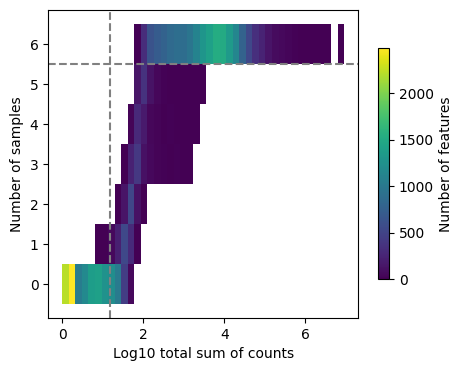

In [ ]:
# Quality Control (optional but recommended)
# --- only the genes in the upper-right corner are going to be kept
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata_filtered = adata[:, genes].copy()

# Normalize total-count per million, CPM (library-size correct)
sc.pp.normalize_total(adata_filtered, target_sum=1e6)

# Store normalized counts in layers
adata_filtered.layers['cpm'] = adata_filtered.X

# Visualize adata
adata_filtered

In [ ]:
# Convert anndata to dataframe
mat = adata_filtered.to_df(layer='cpm')
mat

GeneName       RP11-34P13.7  RP11-34P13.8    CICP27  FO538757.2  AP006222.2  \
25_HSCs-Ctrl1      0.861613      0.600518  2.637059    1.305475    1.853774   
26_HSCs-Ctrl2      1.341323      0.914539  2.581031    0.751954    0.975508   
27_HSCs-Ctrl3      0.969110      0.633649  2.012767    0.838653    1.062294   
31_HSCs-TGFb1      0.965408      0.536338  2.592299    0.500582    1.841426   
32_HSCs-TGFb2      1.027534      0.653885  1.821537    0.607179    1.447888   
33_HSCs-TGFb3      0.796692      0.522829  2.190902    0.423242    1.468900   

GeneName       RP4-669L17.10   MTND1P23   MTND2P28  AC114498.1     MIR6723  \
25_HSCs-Ctrl1       0.496080  20.391516  51.644581   12.323682  628.011658   
26_HSCs-Ctrl2       0.934862  18.026571  48.328281    9.734755  522.831543   
27_HSCs-Ctrl3       0.465918  20.779961  56.823406   10.138384  572.576416   
31_HSCs-TGFb1       0.536338  15.375017  44.802082    7.937799  367.212616   
32_HSCs-TGFb2       0.607179   9.457981  26.295525    7.146030  227.505325   
33_HSCs-TGFb3       0.248966  15.037556  47.253777    7.070639  369.415955   

GeneName       ...       MT-ND4     MT-TH     MT-TS2     MT-TL2       MT-ND5  \
25_HSCs-Ctrl1  ...  2433.196045  8.929447  12.428120  12.871981  1422.079712   
26_HSCs-Ctrl2  ...  2335.406250  7.214693   7.885355   8.860863  1314.862549   
27_HSCs-Ctrl3  ...  2895.496338  7.026049   8.162890   8.945633  1596.236328   
31_HSCs-TGFb1  ...  1982.054199  6.668467   7.884166   8.599282  1078.485962   
32_HSCs-TGFb2  ...  1062.283081  5.581377   7.729856   8.010093   640.854126   
33_HSCs-TGFb3  ...  1760.290283  8.564435  11.278167  12.373617  1131.376831   

GeneName           MT-ND6      MT-TE       MT-CYB     MT-TT      MT-TP  
25_HSCs-Ctrl1  448.665558  33.994560  1412.497559  6.736249  12.402010  
26_HSCs-Ctrl2  428.938904  30.322033  1273.830200  5.141739   8.047939  
27_HSCs-Ctrl3  593.766357  37.888481  1669.087402  5.255559   8.349257  
31_HSCs-TGFb1  348.548065  25.869360  1185.002563  3.075003   6.096373  
32_HSCs-TGFb2  211.438431  14.572297   643.026001  2.241892   5.044257  
33_HSCs-TGFb3  343.473694  26.813654  1080.886475  4.780150   6.049877  

[6 rows x 17575 columns]

In [ ]:
mat.apply([np.sum, np.min, np.max], axis=1)

sum      amin          amax
25_HSCs-Ctrl1  1.000000e+06  0.234985  16724.437500
26_HSCs-Ctrl2  1.000000e+06  0.223554  20666.802734
27_HSCs-Ctrl3  1.000000e+06  0.223641  21531.746094
31_HSCs-TGFb1  1.000000e+06  0.232413  53465.296875
32_HSCs-TGFb2  1.000000e+06  0.233530  55140.593750
33_HSCs-TGFb3  1.000000e+06  0.224070  59497.929688

### **TASK 1** Without DEA

#### Calculate the TF activity

In [ ]:
# Infer TF activities with ulm using CollecTRI network
tf_collectri_acts, tf_collectri_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_collectri_acts
# tf_collectri_acts.apply([np.sum, np.min, np.max], axis=1)
# tf_collectri_acts.shape

Running ulm on mat with 6 samples and 17575 targets for 629 sources.


ABL1       AHR      AIRE       AP1     APEX1        AR  \
25_HSCs-Ctrl1  1.065369  3.513768 -0.092619  9.416823  3.750810  7.374182   
26_HSCs-Ctrl2  1.030500  3.439764 -0.108949  9.543247  3.511437  7.277483   
27_HSCs-Ctrl3  1.062467  3.423932 -0.105873  9.529863  3.719286  7.011393   
31_HSCs-TGFb1  0.341344  2.637449 -0.137243  9.362064  1.862120  8.492096   
32_HSCs-TGFb2  0.341261  2.539009 -0.125790  9.223310  1.679006  8.553974   
33_HSCs-TGFb3  0.310873  2.437673 -0.130148  9.481165  1.448070  8.715354   

                 ARID1A    ARID3A    ARID3B    ARID4A  ...   ZNF354C  \
25_HSCs-Ctrl1  2.209627  0.792456 -0.073562 -0.119644  ...  2.369821   
26_HSCs-Ctrl2  2.080467  0.805713 -0.070083 -0.108495  ...  2.047254   
27_HSCs-Ctrl3  2.019213  0.803646 -0.044515 -0.098158  ...  2.195279   
31_HSCs-TGFb1  0.501636  0.297469 -0.033156 -0.101031  ...  0.258564   
32_HSCs-TGFb2  0.518021  0.306204 -0.041595 -0.098013  ...  0.221584   
33_HSCs-TGFb3  0.467010  0.262756 -0.043612 -0.103782  ...  0.259061   

                 ZNF362    ZNF382     ZNF384    ZNF395    ZNF436    ZNF699  \
25_HSCs-Ctrl1  1.127670 -0.358643  17.152018 -0.152018  0.223835  0.792804   
26_HSCs-Ctrl2  1.055401 -0.310071  19.226736 -0.127963  0.200891  0.684690   
27_HSCs-Ctrl3  1.095722 -0.281857  19.752375 -0.130376  0.231477  0.739110   
31_HSCs-TGFb1  0.462094 -0.082978  16.974936 -0.076635  0.083366  0.223191   
32_HSCs-TGFb2  0.438338 -0.116582  16.314453 -0.093113  0.047600  0.247142   
33_HSCs-TGFb3  0.411983 -0.123147  14.641565 -0.087410  0.042556  0.246827   

                  ZNF76   ZNF804A     ZNF91  
25_HSCs-Ctrl1 -0.641132 -0.200024  1.450069  
26_HSCs-Ctrl2 -0.659765 -0.191540  1.307216  
27_HSCs-Ctrl3 -0.655897 -0.193930  1.433861  
31_HSCs-TGFb1 -0.273286 -0.090176  0.539266  
32_HSCs-TGFb2 -0.285474 -0.080971  0.547607  
33_HSCs-TGFb3 -0.249543 -0.083871  0.495250  

[6 rows x 629 columns]

In [ ]:
# Infer TF activities with ulm using DoRothEA network
tf_dorothea_acts, tf_dorothea_pvals = dc.run_ulm(mat=mat, net=dorothea, verbose=True)
tf_dorothea_acts
# tf_dorothea_acts.apply([np.sum, np.min, np.max], axis=1)
# tf_dorothea_acts.shape

Running ulm on mat with 6 samples and 17575 targets for 281 sources.


AHR        AR     ARID2    ARID3A      ARNT     ASCL1  \
25_HSCs-Ctrl1  1.021086  3.672184  0.669489  0.081744  2.697176  0.406037   
26_HSCs-Ctrl2  0.837120  3.125765  0.522897  0.059671  2.484155  0.425281   
27_HSCs-Ctrl3  0.733425  3.235074  0.362701  0.039755  2.302288  0.379323   
31_HSCs-TGFb1  0.146720  1.907997  0.176476  0.030676  1.489435  0.167627   
32_HSCs-TGFb2  0.142365  1.933520  0.198579  0.066514  1.523887  0.155074   
33_HSCs-TGFb3  0.148002  1.912735  0.190550  0.049040  1.451231  0.150502   

                   ATF1       ATF2      ATF3      ATF4  ...    ZNF217  \
25_HSCs-Ctrl1  1.640476   9.651978  0.612117  1.249952  ...  1.153679   
26_HSCs-Ctrl2  1.518833  11.370803  0.600986  1.228788  ...  1.089787   
27_HSCs-Ctrl3  1.453785   9.988415  0.632513  1.174859  ...  0.941741   
31_HSCs-TGFb1  0.882310  24.084148  0.323295  0.646517  ...  0.294664   
32_HSCs-TGFb2  0.908797  24.430395  0.302602  0.680592  ...  0.323096   
33_HSCs-TGFb3  0.834315  25.430475  0.284248  0.620383  ...  0.334270   

                  ZNF24    ZNF263    ZNF274    ZNF384    ZNF584    ZNF592  \
25_HSCs-Ctrl1 -0.362536  2.313812 -0.243042  1.458922  0.229469  0.236344   
26_HSCs-Ctrl2 -0.348231  2.313849 -0.225304  1.381332  0.223435  0.209429   
27_HSCs-Ctrl3 -0.352394  2.391270 -0.243336  1.257836  0.177968  0.197425   
31_HSCs-TGFb1 -0.155068  0.951346 -0.236343  0.557975  0.017112  0.024222   
32_HSCs-TGFb2 -0.145248  0.818233 -0.234875  0.546379  0.014626  0.004064   
33_HSCs-TGFb3 -0.142322  0.814429 -0.233602  0.530376  0.006014 -0.006023   

                 ZNF639    ZNF644    ZNF740  
25_HSCs-Ctrl1  0.888968 -0.119325  0.818214  
26_HSCs-Ctrl2  0.743977 -0.103536  0.821655  
27_HSCs-Ctrl3  0.655634 -0.124677  0.821915  
31_HSCs-TGFb1  0.267927 -0.058889  0.247535  
32_HSCs-TGFb2  0.317364 -0.036936  0.213982  
33_HSCs-TGFb3  0.318174 -0.029797  0.211474  

[6 rows x 281 columns]

In [ ]:
# Filter p-value < 0.05 in collectri TF activity
tf_collectri_acts_filtered = tf_collectri_acts.loc[:, tf_collectri_pvals.lt(0.05).all()]
tf_collectri_acts_filtered.shape

(6, 173)

In [ ]:
# Filter p-value < 0.05 in dorothea TF activity
tf_dorothea_acts_filtered = tf_dorothea_acts.loc[:, tf_dorothea_pvals.lt(0.05).all()]
tf_dorothea_acts_filtered.shape

(6, 57)

In [ ]:
# Find ALL common columns
matched_columns = tf_collectri_acts.columns.intersection(tf_dorothea_acts.columns)

# Merge two dataframes based on the matched columns
df_merged = pd.merge(tf_collectri_acts[matched_columns], tf_dorothea_acts[matched_columns], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

df_merged

AHR_collectri  AR_collectri  ARID3A_collectri  ARNT_collectri  \
25_HSCs-Ctrl1       3.513768      7.374182          0.792456        1.198286   
26_HSCs-Ctrl2       3.439764      7.277483          0.805713        1.125570   
27_HSCs-Ctrl3       3.423932      7.011393          0.803646        1.120977   
31_HSCs-TGFb1       2.637449      8.492096          0.297469        1.458125   
32_HSCs-TGFb2       2.539009      8.553974          0.306204        1.344882   
33_HSCs-TGFb3       2.437673      8.715354          0.262756        1.456021   

               ASCL1_collectri  ATF1_collectri  ATF2_collectri  \
25_HSCs-Ctrl1         2.654510        2.785471        6.056330   
26_HSCs-Ctrl2         2.602200        2.350424        6.752047   
27_HSCs-Ctrl3         2.618362        2.621725        6.114440   
31_HSCs-TGFb1         1.839883       -0.137174       12.579825   
32_HSCs-TGFb2         1.748260       -0.229812       12.704719   
33_HSCs-TGFb3         1.636797       -0.143629       13.176441   

               ATF3_collectri  ATF4_collectri  ATF6_collectri  ...  \
25_HSCs-Ctrl1        5.635913        3.636624        2.615047  ...   
26_HSCs-Ctrl2        6.186154        3.380385        2.349293  ...   
27_HSCs-Ctrl3        5.627210        3.414000        2.376799  ...   
31_HSCs-TGFb1       13.259231        1.412705        1.391680  ...   
32_HSCs-TGFb2       13.202457        1.277132        1.351969  ...   
33_HSCs-TGFb3       14.049950        1.349135        1.276085  ...   

               YY1_dorothea  ZBED1_dorothea  ZBTB33_dorothea  ZBTB7A_dorothea  \
25_HSCs-Ctrl1      0.120190        0.830525         1.316495         3.326636   
26_HSCs-Ctrl2      0.217628        0.697476         1.146904         3.190058   
27_HSCs-Ctrl3      0.147464        0.715901         1.008755         3.540641   
31_HSCs-TGFb1      0.387686        0.173485         0.386527         1.383568   
32_HSCs-TGFb2      0.391979        0.165230         0.429917         1.166487   
33_HSCs-TGFb3      0.372879        0.147714         0.397987         1.039810   

               ZEB1_dorothea  ZEB2_dorothea  ZHX2_dorothea  ZNF143_dorothea  \
25_HSCs-Ctrl1       7.565924       5.333564       1.066102         0.994266   
26_HSCs-Ctrl2       7.463633       5.112087       0.990801         1.010280   
27_HSCs-Ctrl3       7.073108       5.214593       1.036648         1.007952   
31_HSCs-TGFb1       5.270473       2.422393       0.286207         0.401297   
32_HSCs-TGFb2       5.183165       2.139276       0.290495         0.342633   
33_HSCs-TGFb3       5.175720       2.219488       0.273864         0.341225   

               ZNF263_dorothea  ZNF384_dorothea  
25_HSCs-Ctrl1         2.313812         1.458922  
26_HSCs-Ctrl2         2.313849         1.381332  
27_HSCs-Ctrl3         2.391270         1.257836  
31_HSCs-TGFb1         0.951346         0.557975  
32_HSCs-TGFb2         0.818233         0.546379  
33_HSCs-TGFb3         0.814429         0.530376  

[6 rows x 482 columns]

In [ ]:
# Find FILTERED common columns
matched_columns_filtered = tf_collectri_acts_filtered.columns.intersection(tf_dorothea_acts_filtered.columns)

# Merge two dataframes based on the matched columns
df_merged_filtered = pd.merge(tf_collectri_acts_filtered[matched_columns_filtered], tf_dorothea_acts_filtered[matched_columns_filtered], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

df_merged_filtered

ATF2_collectri  CEBPA_collectri  CEBPD_collectri  \
25_HSCs-Ctrl1        6.056330         8.215017        12.066716   
26_HSCs-Ctrl2        6.752047         8.492769        13.137196   
27_HSCs-Ctrl3        6.114440         8.557335        13.533414   
31_HSCs-TGFb1       12.579825        10.044015        10.411624   
32_HSCs-TGFb2       12.704719         9.849190         9.993420   
33_HSCs-TGFb3       13.176441        10.455815         9.000201   

               CREB1_collectri  EGR1_collectri  EPAS1_collectri  \
25_HSCs-Ctrl1         4.755984       13.301751         5.399525   
26_HSCs-Ctrl2         5.057590       14.168164         5.133511   
27_HSCs-Ctrl3         4.855953       14.076419         5.307034   
31_HSCs-TGFb1         7.482423       15.055024         3.774556   
32_HSCs-TGFb2         7.463739       14.845440         3.582222   
33_HSCs-TGFb3         7.759928       14.868939         3.514696   

               ESR1_collectri  ETS1_collectri  ETV4_collectri  FOS_collectri  \
25_HSCs-Ctrl1        7.085041       14.381563        4.153017       6.428141   
26_HSCs-Ctrl2        6.670248       15.632476        3.927345       6.732810   
27_HSCs-Ctrl3        6.840119       15.508755        4.085566       6.345921   
31_HSCs-TGFb1        3.922930       17.165949        2.378347      10.100188   
32_HSCs-TGFb2        3.836319       16.888117        2.262217      10.148149   
33_HSCs-TGFb3        3.788261       16.933939        2.132518      10.375518   

               ...  SP1_dorothea  SP3_dorothea  SPI1_dorothea  SRF_dorothea  \
25_HSCs-Ctrl1  ...      7.735653     13.983871       4.112229     15.509757   
26_HSCs-Ctrl2  ...      7.385869     14.917742       3.895115     15.067191   
27_HSCs-Ctrl3  ...      7.087571     15.393705       3.607999     15.241090   
31_HSCs-TGFb1  ...      8.689702     13.517368       2.119456     12.022268   
32_HSCs-TGFb2  ...      8.812040     13.180999       2.234537     11.524851   
33_HSCs-TGFb3  ...      9.433439     12.157229       2.192419     10.800351   

               STAT1_dorothea  TBP_dorothea  TFAP2A_dorothea  TWIST1_dorothea  \
25_HSCs-Ctrl1        9.836035     14.597396        11.111717         4.925829   
26_HSCs-Ctrl2       10.011469     17.094852        10.254299         4.362162   
27_HSCs-Ctrl3       10.083284     15.343170        10.903830         4.261085   
31_HSCs-TGFb1        7.619104     35.416481         4.019162         3.815943   
32_HSCs-TGFb2        7.494651     35.726379         3.740860         3.851121   
33_HSCs-TGFb3        6.977996     37.195339         3.848060         3.530662   

               USF1_dorothea  USF2_dorothea  
25_HSCs-Ctrl1       4.796582       5.820758  
26_HSCs-Ctrl2       4.732239       5.762555  
27_HSCs-Ctrl3       4.842383       5.489714  
31_HSCs-TGFb1       4.029725       5.040974  
32_HSCs-TGFb2       3.700996       4.968072  
33_HSCs-TGFb3       3.859724       4.681488  

[6 rows x 66 columns]

In [ ]:
# Filtering to get the target column
regulons_collectri_selected = collectri.loc[collectri['source'] == "RELA", 'target']
# Filtering the 'mat' DataFrame
df_mat_collectri_selected = mat[regulons_collectri_selected[regulons_collectri_selected.isin(mat.columns)].to_list()]

df_mat_collectri_selected

GeneName             FAS     ABCB1       JAG1       TP53        CCND1  \
25_HSCs-Ctrl1  54.803829  1.801555  36.057213  61.357311  1112.107788   
26_HSCs-Ctrl2  51.478359  1.910369  32.598217  64.952560  1222.656738   
27_HSCs-Ctrl3  48.064140  0.987747  30.787886  64.129005  1372.353271   
31_HSCs-TGFb1  30.821545  0.250291  13.533590  38.938126   876.125671   
32_HSCs-TGFb2  31.526606  0.326943  13.404645  33.885262   759.230713   
33_HSCs-TGFb3  30.896698  0.448139  13.991898  31.145664   868.792297   

GeneName             PLAU      CXCL8        IL6      ICAM1      VCAM1  ...  \
25_HSCs-Ctrl1  614.434753  70.521744   8.694462  55.352127  70.704514  ...   
26_HSCs-Ctrl2  581.402649  53.327759   7.885355  74.484085  42.556526  ...   
27_HSCs-Ctrl3  632.586731  58.407528   6.839682  68.955917  66.626328  ...   
31_HSCs-TGFb1   98.114059  12.228501  12.639694   8.688672   0.911774  ...   
32_HSCs-TGFb2   92.478043  14.362120  13.825000  11.583108   1.074240  ...   
33_HSCs-TGFb3   95.827072  16.108110  14.265760  10.655751   1.419107  ...   

GeneName              JUN      CASP8      FOSL1        CAV1       CYBA  \
25_HSCs-Ctrl1  111.983620  20.522062  57.023136  641.719177  49.399162   
26_HSCs-Ctrl2  117.020287  18.107862  79.097420  684.196777  43.166218   
27_HSCs-Ctrl3  127.661636  17.164433  88.133118  690.565613  48.418240   
31_HSCs-TGFb1   69.992081   9.439546  41.584057  607.348938  33.682014   
32_HSCs-TGFb2   65.388512  11.372931  33.511612  666.402344  29.261360   
33_HSCs-TGFb3   68.266518   8.390160  31.892563  628.888489  30.174698   

GeneName            PGF      GALK1      SNAI2     HSPA1A     HSPA1B  
25_HSCs-Ctrl1  0.626628  15.247945  82.845428  39.503666  38.615944  
26_HSCs-Ctrl2  0.589369  14.856171  69.504929  42.902020  39.772266  
27_HSCs-Ctrl3  0.559102  15.505764  70.316399  40.833088  36.770279  
31_HSCs-TGFb1  0.947530  11.406117  40.958328  41.083473  32.484192  
32_HSCs-TGFb2  0.397002   9.925042  45.141426  38.345692  29.121243  
33_HSCs-TGFb3  0.622415  10.332095  42.249554  34.307533  27.311586  

[6 rows x 333 columns]

#### Plot the result

In [ ]:
tf = "RFX5"

# # Filtering to get the target column
# regulons_collectri = collectri.loc[collectri['source'] == tf, 'target']
# regulons_dorothea = dorothea.loc[dorothea['source'] == tf, 'target']

# # Filtering the 'mat' DataFrame
# df_mat_collectri = mat[regulons_collectri[regulons_collectri.isin(mat.columns)].to_list()]
# df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.isin(mat.columns)].to_list()]

# # Convert the weight values
# weights_sign_collectri = collectri.set_index('target').loc[regulons_collectri, 'weight'].apply(np.sign).to_dict()
# weights_sign_dorothea = dorothea.set_index('target').loc[regulons_dorothea, 'weight'].apply(np.sign).to_dict()

# Filtering to get the target column
regulons_collectri = collectri.loc[collectri['source'] == tf, ['target','weight']]
regulons_dorothea = dorothea.loc[dorothea['source'] == tf, ['target','weight']]

# Filtering the 'mat' DataFrame
df_mat_collectri = mat[regulons_collectri[regulons_collectri.target.isin(mat.columns)].target.to_list()]
df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.target.isin(mat.columns)].target.to_list()]

# Convert the weight values
weights_sign_collectri = regulons_collectri.set_index('target').weight.apply(np.sign).to_dict()
weights_sign_dorothea = regulons_dorothea.set_index('target').weight.apply(np.sign).to_dict()

# Multiply the matrices by the sign of weight values
for col in df_mat_collectri.columns:
    df_mat_collectri[col] *= weights_sign_collectri.get(col, 1)

for col in df_mat_dorothea.columns:
    df_mat_dorothea[col] *= weights_sign_dorothea.get(col, 1)

# Compute the Pearson correlation
correlation_collectri = df_mat_collectri.corr()
correlation_dorothea = df_mat_dorothea.corr()

# Sort the correlation matrices by the average correlation value
sorted_columns_collectri = correlation_collectri.mean().sort_values(ascending=False).index
sorted_columns_dorothea = correlation_dorothea.mean().sort_values(ascending=False).index

correlation_collectri = correlation_collectri.loc[sorted_columns_collectri, sorted_columns_collectri]
correlation_dorothea = correlation_dorothea.loc[sorted_columns_dorothea, sorted_columns_dorothea]

# Reorder the columns of df_mat_collectri to match the order in correlation_collectri
df_mat_collectri = df_mat_collectri[correlation_collectri.columns]

# Reorder the columns of df_mat_dorothea to match the order in correlation_dorothea
df_mat_dorothea = df_mat_dorothea[correlation_dorothea.columns]

df_mat_collectri

GeneName         HLA-DMA       HLA-E       RFX5  HLA-DPA1      CIITA  \
25_HSCs-Ctrl1  10.600455  181.121567  37.493233  1.488241  17.937223   
26_HSCs-Ctrl2   9.816047  177.583069  37.170910  1.260031  17.701401   
27_HSCs-Ctrl3   9.914743  187.821014  37.869846  1.360482  17.183069   
31_HSCs-TGFb1   2.467154   74.407928  26.209040  0.732995  13.980538   
32_HSCs-TGFb2   2.475422   76.224327  24.941048  0.747297  14.175296   
33_HSCs-TGFb3   2.614145   71.702248  22.954679  0.821588  13.294792   

GeneName       HLA-DPB1        COL1A2      SIN3B     HLA-G     HLA-F  \
25_HSCs-Ctrl1  3.446453 -12759.945312  74.255402  5.326337  1.227146   
26_HSCs-Ctrl2  3.251693 -14364.779297  74.158913  5.751431  1.077123   
27_HSCs-Ctrl3  2.963241 -14437.971680  78.814751  6.485584  2.012767   
31_HSCs-TGFb1  1.465990 -16066.767578  65.397453  4.505238  1.036920   
32_HSCs-TGFb2  1.144299 -16509.736328  58.756248  4.296959  0.840709   
33_HSCs-TGFb3  1.244831 -16450.636719  59.428219  4.929530  0.846485   

GeneName           SIRT1       HDAC2  
25_HSCs-Ctrl1  29.895370  123.210709  
26_HSCs-Ctrl2  24.773832  116.715439  
27_HSCs-Ctrl3  23.966841  109.677185  
31_HSCs-TGFb1  22.865868  128.292007  
32_HSCs-TGFb2  26.482347  131.781204  
33_HSCs-TGFb3  22.680817  124.358589

In [ ]:
df_mat_collectri.corr()

GeneName   HLA-DMA     HLA-E      RFX5  HLA-DPA1     CIITA  HLA-DPB1  \
GeneName                                                               
HLA-DMA   1.000000  0.995496  0.985024  0.984970  0.984690  0.989312   
HLA-E     0.995496  1.000000  0.991117  0.972582  0.980001  0.976991   
RFX5      0.985024  0.991117  1.000000  0.952077  0.986609  0.979236   
HLA-DPA1  0.984970  0.972582  0.952077  1.000000  0.954610  0.969400   
CIITA     0.984690  0.980001  0.986609  0.954610  1.000000  0.985277   
HLA-DPB1  0.989312  0.976991  0.979236  0.969400  0.985277  1.000000   
COL1A2    0.933668  0.904096  0.909891  0.956480  0.933711  0.953905   
SIN3B     0.932694  0.950076  0.965626  0.900278  0.912270  0.927094   
HLA-G     0.835966  0.866935  0.828045  0.810852  0.754875  0.780790   
HLA-F     0.651638  0.704905  0.698635  0.652041  0.586175  0.583200   
SIRT1     0.485528  0.439477  0.445972  0.545909  0.554413  0.494836   
HDAC2    -0.767262 -0.804195 -0.766419 -0.731107 -0.680451 -0.712976   

GeneName    COL1A2     SIN3B     HLA-G     HLA-F     SIRT1     HDAC2  
GeneName                                                              
HLA-DMA   0.933668  0.932694  0.835966  0.651638  0.485528 -0.767262  
HLA-E     0.904096  0.950076  0.866935  0.704905  0.439477 -0.804195  
RFX5      0.909891  0.965626  0.828045  0.698635  0.445972 -0.766419  
HLA-DPA1  0.956480  0.900278  0.810852  0.652041  0.545909 -0.731107  
CIITA     0.933711  0.912270  0.754875  0.586175  0.554413 -0.680451  
HLA-DPB1  0.953905  0.927094  0.780790  0.583200  0.494836 -0.712976  
COL1A2    1.000000  0.843535  0.631171  0.506023  0.672183 -0.537873  
SIN3B     0.843535  1.000000  0.881757  0.814565  0.255483 -0.843300  
HLA-G     0.631171  0.881757  1.000000  0.849699 -0.006609 -0.990910  
HLA-F     0.506023  0.814565  0.849699  1.000000 -0.004391 -0.837374  
SIRT1     0.672183  0.255483 -0.006609 -0.004391  1.000000  0.139394  
HDAC2    -0.537873 -0.843300 -0.990910 -0.837374  0.139394  1.000000

In [ ]:
weights_sign_collectri

{'HLA-E': 1,
 'CIITA': 1,
 'RFX5': 1,
 'COL1A2': -1,
 'HLA-G': 1,
 'IFNG': 1,
 'SIRT1': 1,
 'SIN3B': 1,
 'CR2': 1,
 'HLA-F': 1,
 'HDAC2': 1,
 'HLA-DMA': 1,
 'HLA-DMB': 1,
 'HLA-DOA': 1,
 'HLA-DOB': 1,
 'HLA-DPA1': 1,
 'HLA-DPB1': 1,
 'HLA-DQA1': 1,
 'HLA-DQA2': 1,
 'HLA-DQB1': 1,
 'HLA-DQB2': 1,
 'HLA-DRA': 1,
 'HLA-DRB1': 1,
 'HLA-DRB3': 1,
 'HLA-DRB4': 1,
 'HLA-DRB5': 1}

In [ ]:
weights_sign_dorothea

{'HLA-DRB5': 1.0,
 'HLA-DRB4': 1.0,
 'HLA-DRB3': 1.0,
 'HLA-DRB1': 1.0,
 'HLA-DQB1': 1.0,
 'HLA-DQA2': 1.0,
 'HLA-DQA1': 1.0,
 'HLA-DPB1': 1.0,
 'HLA-DPA1': 1.0,
 'HLA-DOB': 1.0,
 'HLA-DOA': 1.0,
 'HLA-DMB': 1.0,
 'HLA-DMA': 1.0,
 'HLA-DRA': 1.0,
 'CD74': 1.0,
 'COL1A2': -1.0,
 'BTN2A1': 1.0,
 'BTN2A2': 1.0,
 'BTN3A1': 1.0,
 'MR1': 1.0,
 'PSMB8': 1.0,
 'TSPAN3': 1.0,
 'BTN3A2': 1.0,
 'BRD2': 1.0,
 'BCAT2': 1.0,
 'B2M': 1.0,
 'ARVCF': 1.0,
 'ARAP1': 1.0,
 'AP2S1': 1.0,
 'ABCC1': 1.0,
 'ABAT': 1.0,
 'ALDOA': 1.0,
 'BTN3A3': 1.0,
 'CABIN1': 1.0,
 'CDK2AP2': 1.0,
 'TPP1': 1.0,
 'TOP2B': 1.0,
 'TMEM231': 1.0,
 'THADA': 1.0,
 'TAP2': 1.0,
 'SYBU': 1.0,
 'TRAK1': 1.0,
 'SULT2B1': 1.0,
 'RHOF': 1.0,
 'RHNO1': 1.0,
 'RAB4B': 1.0,
 'PTPN13': 1.0,
 'PSMD3': 1.0,
 'PSMB9': 1.0,
 'SOX12': 1.0,
 'PPP2R1B': 1.0,
 'TRIM26': 1.0,
 'TTC7A': 1.0,
 'ZNF672': 1.0,
 'WIPF2': 1.0,
 'VPS26C': 1.0,
 'TTC9C': 1.0,
 'PNRC1': 1.0,
 'PER1': 1.0,
 'IQCG': 1.0,
 'HNRNPUL2': 1.0,
 'HAUS5': 1.0,
 'GTF2I': 1.0,
 'GSTCD

In [ ]:
# The values of "COL1A2"
mat["COL1A2"]

25_HSCs-Ctrl1    12759.945312
26_HSCs-Ctrl2    14364.779297
27_HSCs-Ctrl3    14437.971680
31_HSCs-TGFb1    16066.767578
32_HSCs-TGFb2    16509.736328
33_HSCs-TGFb3    16450.636719
Name: COL1A2, dtype: float32

In [ ]:
# The weight of "COL1A2" in "RFX5" from CollecTRI
collectri.loc[(collectri.target == "COL1A2") & (collectri.source == "RFX5"), :]

source  target  weight                                 PMID
6354   RFX5  COL1A2      -1  12968017;15247294;16464847;23079621

In [ ]:
# Test original COL1A2
tf_collectri_acts_keeps, tf_collectri_pvals_keeps = dc.run_ulm(mat=mat, net=collectri, verbose=True)

print(f"TF actual activity: {np.mean(tf_collectri_acts_keeps['RFX5']):.2f}")
print(f"TF actual p-value:  {np.mean(tf_collectri_pvals_keeps['RFX5']):.4f}")

Running ulm on mat with 6 samples and 17575 targets for 629 sources.
TF actual activity: -11.24
TF p-value:         0.0000


In [ ]:
# Test remove COL1A2
mat_removed = mat.copy().drop(columns="COL1A2")
tf_collectri_acts_removed, tf_collectri_pvals_removed = dc.run_ulm(mat=mat_removed, net=collectri, verbose=True)

print(f"TF modified activity: {np.mean(tf_collectri_acts_removed['RFX5']):.2f}")
print(f"TF modified p-value:  {np.mean(tf_collectri_pvals_removed['RFX5']):.4f}")

Running ulm on mat with 6 samples and 17574 targets for 629 sources.
TF modified activity: -0.15
TF modified p-value:  0.8771


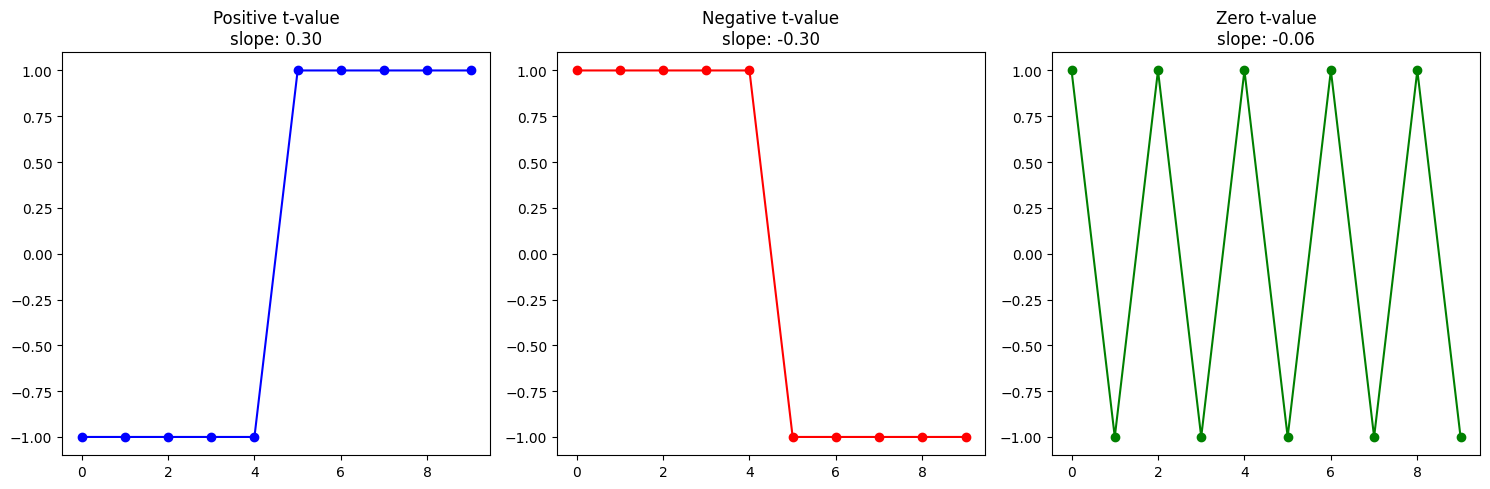

In [ ]:
# Example of t-value of the slope in mock-up data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Mock-up data
x = np.array(range(10))

# Positive slope: y increases as x increases
y_positive = np.array([-1, -1, -1, -1, -1, 1, 1, 1, 1, 1])

# Negative slope: y decreases as x increases
y_negative = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])

# No slope: y doesn't change with x
y_zero = np.array([1, -1, 1, -1, 1, -1, 1, -1, 1, -1])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(x, y_positive, color='blue')
axes[0].plot(x, y_positive, color='blue')
axes[0].set_title(f"Positive t-value\nslope: {linregress(x, y_positive).slope:.2f}")

axes[1].scatter(x, y_negative, color='red')
axes[1].plot(x, y_negative, color='red')
axes[1].set_title(f"Negative t-value\nslope: {linregress(x, y_negative).slope:.2f}")

axes[2].scatter(x, y_zero, color='green')
axes[2].plot(x, y_zero, color='green')
axes[2].set_title(f"Zero t-value\nslope: {linregress(x, y_zero).slope:.2f}")

plt.tight_layout()
plt.show()


In [ ]:
correlation_collectri

GeneName   HLA-DMA     HLA-E      RFX5  HLA-DPA1     CIITA  HLA-DPB1  \
GeneName                                                               
HLA-DMA   1.000000  0.995496  0.985024  0.984970  0.984690  0.989312   
HLA-E     0.995496  1.000000  0.991117  0.972582  0.980001  0.976991   
RFX5      0.985024  0.991117  1.000000  0.952077  0.986609  0.979236   
HLA-DPA1  0.984970  0.972582  0.952077  1.000000  0.954610  0.969400   
CIITA     0.984690  0.980001  0.986609  0.954610  1.000000  0.985277   
HLA-DPB1  0.989312  0.976991  0.979236  0.969400  0.985277  1.000000   
COL1A2    0.933668  0.904096  0.909891  0.956480  0.933711  0.953905   
SIN3B     0.932694  0.950076  0.965626  0.900278  0.912270  0.927094   
HLA-G     0.835966  0.866935  0.828045  0.810852  0.754875  0.780790   
HLA-F     0.651638  0.704905  0.698635  0.652041  0.586175  0.583200   
SIRT1     0.485528  0.439477  0.445972  0.545909  0.554413  0.494836   
HDAC2    -0.767262 -0.804195 -0.766419 -0.731107 -0.680451 -0.712976   

GeneName    COL1A2     SIN3B     HLA-G     HLA-F     SIRT1     HDAC2  
GeneName                                                              
HLA-DMA   0.933668  0.932694  0.835966  0.651638  0.485528 -0.767262  
HLA-E     0.904096  0.950076  0.866935  0.704905  0.439477 -0.804195  
RFX5      0.909891  0.965626  0.828045  0.698635  0.445972 -0.766419  
HLA-DPA1  0.956480  0.900278  0.810852  0.652041  0.545909 -0.731107  
CIITA     0.933711  0.912270  0.754875  0.586175  0.554413 -0.680451  
HLA-DPB1  0.953905  0.927094  0.780790  0.583200  0.494836 -0.712976  
COL1A2    1.000000  0.843535  0.631171  0.506023  0.672183 -0.537873  
SIN3B     0.843535  1.000000  0.881757  0.814565  0.255483 -0.843300  
HLA-G     0.631171  0.881757  1.000000  0.849699 -0.006609 -0.990910  
HLA-F     0.506023  0.814565  0.849699  1.000000 -0.004391 -0.837374  
SIRT1     0.672183  0.255483 -0.006609 -0.004391  1.000000  0.139394  
HDAC2    -0.537873 -0.843300 -0.990910 -0.837374  0.139394  1.000000

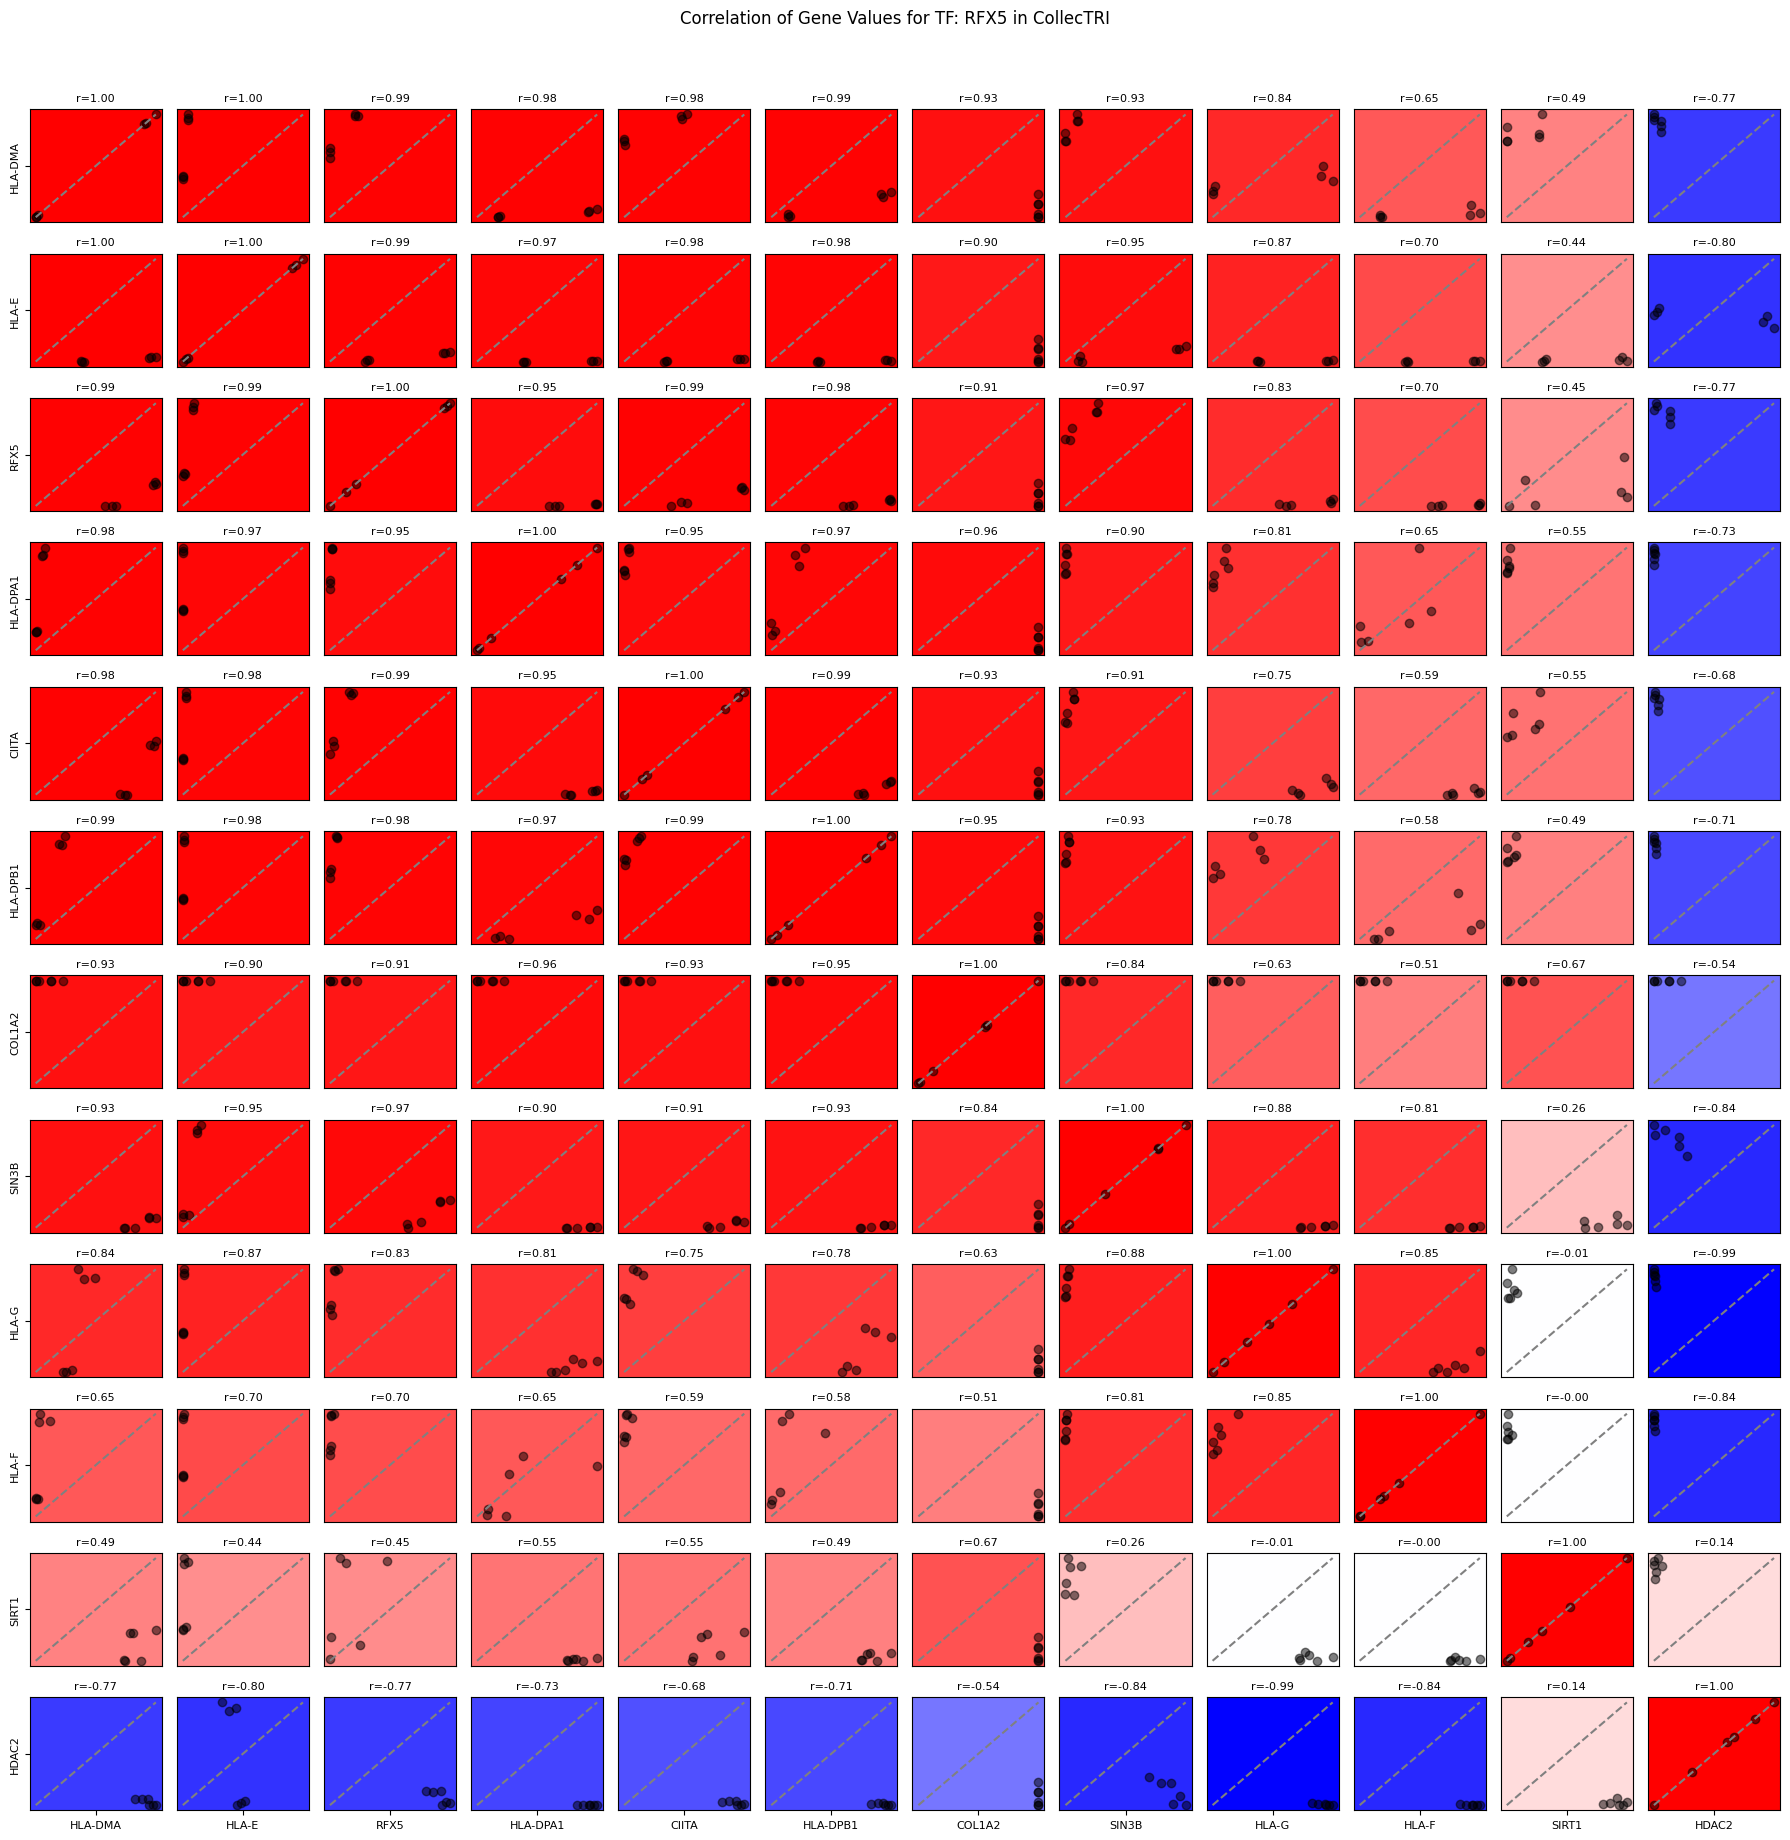

In [ ]:
def plot_corr_hist(df_mat, corr_mat):
    # Number of genes
    n_genes = df_mat.shape[1]

    # Create a grid of subplots
    fig, axes = plt.subplots(n_genes, n_genes, figsize=(18, 18))

    # Set a global title
    fig.suptitle(f'Correlation of Gene Values for TF: {tf} in CollecTRI', y=1.02)

    for i in range(n_genes):
        for j in range(n_genes):
            # Plotting scatter for each gene vs. each gene
            axes[i, j].scatter(df_mat.iloc[:, i], df_mat.iloc[:, j], color='black', alpha=0.5)

            # Plot the 45-degree line
            min_val = min(df_mat.iloc[:, i].min(), df_mat.iloc[:, j].min())
            max_val = max(df_mat.iloc[:, i].max(), df_mat.iloc[:, j].max())
            axes[i, j].plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--')

            # Fetch the correlation value from corr_mat
            corr_value = corr_mat.iloc[i, j]

            # Set background color based on the correlation value using a colormap (blue-white-red)
            axes[i, j].set_facecolor(plt.cm.bwr((corr_value + 1) / 2)) # normalize corr_value to [0,1]

            # Set the title as the correlation value
            axes[i, j].set_title(f'r={corr_value:.2f}', fontsize=8)

            # Hide x and y ticks for clarity
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            # Calculate positions for x and y axis labels based on data range
            median_val = (max_val + min_val) / 2

            # For bottom row subplots, set x-axis labels
            if i == n_genes - 1:
                axes[i, j].set_xticks([median_val])  # Displaying at mean for centered appearance
                axes[i, j].set_xticklabels([corr_mat.columns[j]], rotation=0, fontsize=8, ha="center")

            # For leftmost column subplots, set y-axis labels
            if j == 0:
                axes[i, j].set_yticks([median_val])  # Displaying at mean for centered appearance
                axes[i, j].set_yticklabels([corr_mat.index[i]], rotation=90, fontsize=8, va="center")

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

plot_corr_hist(df_mat_collectri, correlation_collectri)

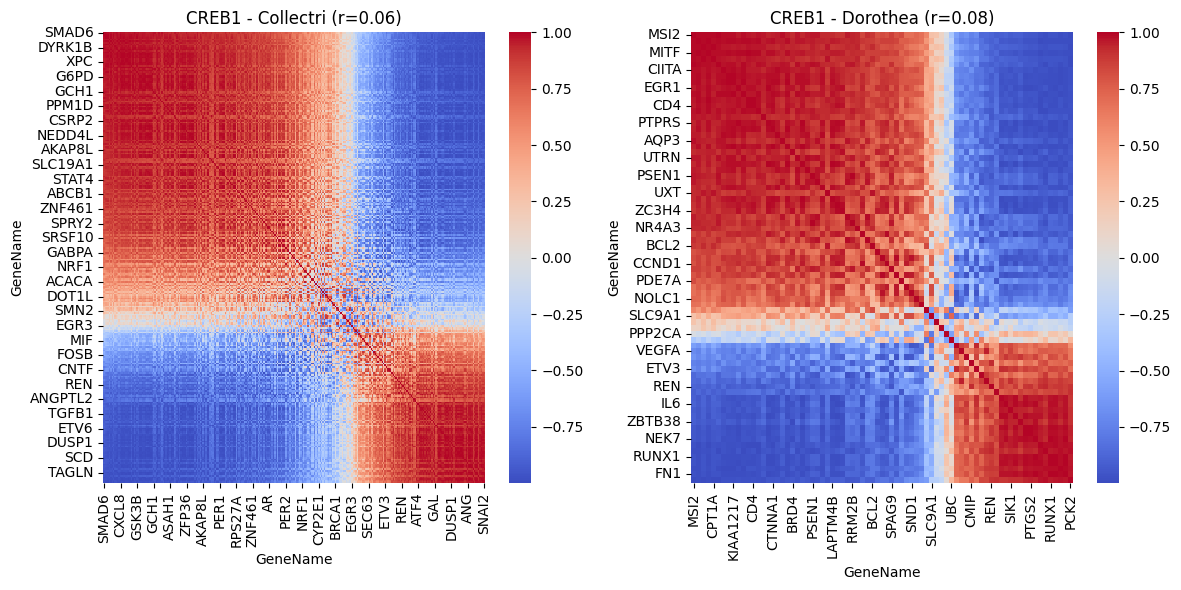

In [ ]:
# Calculate the mean correlation of regulons

tf_lists = matched_columns_filtered.to_list()

# Placeholder for means
means = []

# 1. Loop through each TF in tf_lists:
for tf in tf_lists:

    if not tf == "RELA":
      continue

    # Filtering to get the target column
    regulons_collectri = collectri.loc[collectri['source'] == tf, ['target','weight']]
    regulons_dorothea = dorothea.loc[dorothea['source'] == tf, ['target','weight']]

    # Filtering the 'mat' DataFrame
    df_mat_collectri = mat[regulons_collectri[regulons_collectri.target.isin(mat.columns)].target.to_list()]
    df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.target.isin(mat.columns)].target.to_list()]

    # Convert the weight values
    weights_sign_collectri = regulons_collectri.set_index('target').weight.apply(np.sign).to_dict()
    weights_sign_dorothea = regulons_dorothea.set_index('target').weight.apply(np.sign).to_dict()

    # Multiply the matrices by the sign of weight values
    df_mat_collectri_multiplied = df_mat_collectri.copy()
    df_mat_dorothea_multiplied = df_mat_dorothea.copy()
    for col in df_mat_collectri_multiplied.columns:
        df_mat_collectri_multiplied[col] *= weights_sign_collectri.get(col, 1)

    for col in df_mat_dorothea_multiplied.columns:
        df_mat_dorothea_multiplied[col] *= weights_sign_dorothea.get(col, 1)

    # 4. Compute the Pearson correlation
    correlation_collectri = df_mat_collectri_multiplied.corr()
    correlation_dorothea = df_mat_dorothea_multiplied.corr()

    # Sort the correlation matrices by the average correlation value
    sorted_columns_collectri = correlation_collectri.mean().sort_values(ascending=False).index
    sorted_columns_dorothea = correlation_dorothea.mean().sort_values(ascending=False).index

    correlation_collectri = correlation_collectri.loc[sorted_columns_collectri, sorted_columns_collectri]
    correlation_dorothea = correlation_dorothea.loc[sorted_columns_dorothea, sorted_columns_dorothea]

    # Calculate the mean correlation and store
    # Extract upper triangle of the matrix (excluding the diagonal)
    upper_triangle_collectri = correlation_collectri.where(np.triu(np.ones(correlation_collectri.shape), k=1).astype(bool))
    # Compute the mean of the upper triangle values
    mean_collectri = upper_triangle_collectri.stack().mean()

    # Extract upper triangle of the matrix (excluding the diagonal)
    upper_triangle_dorothea = correlation_dorothea.where(np.triu(np.ones(correlation_dorothea.shape), k=1).astype(bool))
    # Compute the mean of the upper triangle values
    mean_dorothea = upper_triangle_dorothea.stack().mean()

    means.append([tf, mean_collectri, mean_dorothea])

    # Plot correlation matrices
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 6))
    # fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'width_ratios': [5, 1, 5, 1]})

    # Plot the heatmaps for Collectri and Dorothea correlations
    sns.heatmap(correlation_collectri, ax=ax1, cmap='coolwarm')
    ax1.set_title(f"{tf} - Collectri (r={mean_collectri:.2f})")
    sns.heatmap(correlation_dorothea, ax=ax3, cmap='coolwarm')
    ax3.set_title(f"{tf} - Dorothea (r={mean_dorothea:.2f})")

    # # Create a DataFrame for boxplot
    # box_df_collectri = pd.DataFrame({col: df_mat_collectri[col].values for col in sorted_columns_collectri})
    # sns.boxplot(data=box_df_collectri, orient='h', color='white', flierprops=dict(markerfacecolor='black', marker='o'), ax=ax2, boxprops=dict(edgecolor='black'))
    # ax2.set(yticklabels=sorted_columns_collectri, yticks=np.arange(len(sorted_columns_collectri)))
    # ax2.set_title("Collectri")

    # # Create a DataFrame for boxplot
    # box_df_dorothea = pd.DataFrame({col: df_mat_dorothea[col].values for col in sorted_columns_dorothea})
    # sns.boxplot(data=box_df_dorothea, orient='h', color='white', flierprops=dict(markerfacecolor='black', marker='o'), ax=ax4, boxprops=dict(edgecolor='black'))
    # ax4.set(yticklabels=sorted_columns_dorothea, yticks=np.arange(len(sorted_columns_dorothea)))
    # ax4.set_title("Dorothea")

    plt.tight_layout()
    plt.show()


In [ ]:
# Calculate the Jaccard Index
tf_lists = matched_columns_filtered.to_list()

# Placeholder for Jaccard Index values
jaccard_indices = []
jaccard_indices_weight = []

# Placeholder for Jaccard Index values
jaccard_regulons = []

# 1. Loop through each TF in tf_lists:
for tf in tf_lists:
    # # 2. Filtering to get the target column
    # regulons_collectri = collectri.loc[collectri['source'] == tf, 'target']
    # regulons_dorothea = dorothea.loc[dorothea['source'] == tf, 'target']

    # # 3. Filtering the 'mat' DataFrame
    # df_mat_collectri = mat[regulons_collectri[regulons_collectri.isin(mat.columns)].to_list()]
    # df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.isin(mat.columns)].to_list()]

    # # Convert the weight values
    # weights_sign_collectri = collectri.set_index('target').loc[regulons_collectri, 'weight'].apply(np.sign).to_dict()
    # weights_sign_dorothea = dorothea.set_index('target').loc[regulons_dorothea, 'weight'].apply(np.sign).to_dict()

    # Filtering to get the target column
    regulons_collectri = collectri.loc[collectri['source'] == tf, ['target','weight']]
    regulons_dorothea = dorothea.loc[dorothea['source'] == tf, ['target','weight']]

    # Create sets for the targets in each regulon
    targets_collectri = set(regulons_collectri['target'])
    targets_dorothea = set(regulons_dorothea['target'])

    # Get targets that are present in both regulons
    shared_targets = targets_collectri.intersection(targets_dorothea)

    # Compute the intersection and union of the two regulons lists
    intersection = len(targets_collectri.intersection(targets_dorothea))
    union = len(targets_collectri.union(targets_dorothea))

    # Calculate Jaccard Index
    jaccard_index = intersection / union if union != 0 else 0
    jaccard_indices.append([tf, jaccard_index])

    # Filtering the 'mat' DataFrame
    df_mat_collectri = mat[regulons_collectri[regulons_collectri.target.isin(mat.columns)].target.to_list()]
    df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.target.isin(mat.columns)].target.to_list()]

    # Convert the weight values
    weights_sign_collectri = regulons_collectri.set_index('target').weight.apply(np.sign).to_dict()
    weights_sign_dorothea = regulons_dorothea.set_index('target').weight.apply(np.sign).to_dict()

    # Multiply the matrices by the sign of weight values
    for col in df_mat_collectri.columns:
        df_mat_collectri[col] *= weights_sign_collectri.get(col, 1)

    for col in df_mat_dorothea.columns:
        df_mat_dorothea[col] *= weights_sign_dorothea.get(col, 1)

    # Compute the intersection and union for collectri
    intersection_collectri = len(set(df_mat_collectri.columns).intersection(set(regulons_collectri['target'])))
    union_collectri = len(set(df_mat_collectri.columns).union(set(regulons_collectri['target'])))

    # Compute the intersection and union for dorothea
    intersection_dorothea = len(set(df_mat_dorothea.columns).intersection(set(regulons_dorothea['target'])))
    union_dorothea = len(set(df_mat_dorothea.columns).union(set(regulons_dorothea['target'])))

    # Calculate Jaccard Index for both databases
    jaccard_index_collectri = intersection_collectri / union_collectri if union_collectri != 0 else 0
    jaccard_index_dorothea = intersection_dorothea / union_dorothea if union_dorothea != 0 else 0

    jaccard_regulons.append([tf, jaccard_index_collectri, jaccard_index_dorothea])

    # Check for shared targets with same weight directions
    intersection_count = 0
    for target in shared_targets:
        weight_collectri = regulons_collectri.loc[regulons_collectri['target'] == target, 'weight'].values[0]
        weight_dorothea = regulons_dorothea.loc[regulons_dorothea['target'] == target, 'weight'].values[0]
        if np.sign(weight_collectri) == np.sign(weight_dorothea):
            intersection_count += 1

    # Compute the union by considering all distinct targets
    union_count_weight = len(shared_targets)

    # Calculate Jaccard Index for same weight directions
    jaccard_index_weight = intersection_count / union_count_weight if union_count_weight != 0 else 0
    jaccard_indices_weight.append([tf, jaccard_index_weight])

print('Done.')

Done.


In [ ]:
# Convert means to DataFrame
correlation_mean = pd.DataFrame(means, columns=["TF", "regulons_collectri", "regulons_dorothea"])

# Convert Jaccard Indices to DataFrame
jaccard_df = pd.DataFrame(jaccard_indices, columns=["TF", "Jaccard Index"])

# Convert Jaccard Indices to DataFrame
jaccard_weight_df = pd.DataFrame(jaccard_indices_weight, columns=["TF", "Jaccard Weight"])

# Convert Jaccard Regulons Indices to DataFrame
jaccard_df_regulons = pd.DataFrame(jaccard_regulons, columns=["TF", "Jaccard Collectri", "Jaccard Dorothea"])

# Merge the correlation_mean and jaccard_df based on TF
merged_data = pd.merge(correlation_mean, jaccard_df, on='TF')
merged_data = pd.merge(merged_data, jaccard_weight_df, on='TF')
merged_data = pd.merge(merged_data, jaccard_df_regulons, on='TF')

# Calculate the mean of each column
mean_collectri = tf_collectri_acts_filtered.mean()
mean_dorothea = tf_dorothea_acts_filtered.mean()

# Find overlapping column names
overlap_columns = mean_collectri.index.intersection(mean_dorothea.index).tolist()

# Construct a new dataframe
result_df = pd.DataFrame({
    'TF': overlap_columns,
    'tf_collectri': mean_collectri[overlap_columns],
    'tf_dorothea': mean_dorothea[overlap_columns]
})

# Merge to get the sorting order from earlier data (based on Jaccard Index)
merged_result = result_df.reset_index(drop=True).merge(merged_data, on='TF', how='inner')

# Adding a new column for marker type based on the conditions provided
conditions = [
    (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] > 0),
    (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] < 0),
    (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] < 0),
    (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] > 0)
]

choices = ['o', 's', '^', 'v'] # circle, square, triangle_up, triangle_down

merged_result['marker'] = np.select(conditions, choices, default='o')

def classify_tf_group(row):
    tf_col = row['tf_collectri']
    tf_dor = row['tf_dorothea']

    if tf_col > 0 and tf_dor > 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 2
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
            return 3
        else:
            return 1
    elif tf_col < 0 and tf_dor < 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 5
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
            return 6
        else:
            return 4
    elif tf_col > 0 and tf_dor < 0:
        return 7
    elif tf_col < 0 and tf_dor > 0:
        return 8

merged_result['tf_group'] = merged_result.apply(classify_tf_group, axis=1)

# Sort the merged data by Jaccard Index in descending order
merged_result = merged_result.sort_values(by='Jaccard Index', ascending=False)

# # Create a colormap based on unique TFs
# cmap = sns.color_palette('hls', n_colors=len(merged_result['TF'].unique()))
# color_dict = dict(zip(merged_result['TF'].unique(), cmap))

# Create a colormap based on unique tf_group
# Green, Red, Orange, Blue, Purple, Pink, Dark Grey, Light Grey
cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]
color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))

merged_result.to_csv("merged_result_33.csv",index=False)
merged_result

TF  tf_collectri  tf_dorothea  regulons_collectri  regulons_dorothea  \
18    RELA      3.242743   -12.932334            0.087019           0.065716   
23     SP1     10.333795     8.190713            0.090725           0.052092   
31    USF1      6.551861     4.326942            0.130901           0.162630   
32    USF2      3.730333     5.293927            0.072704           0.265408   
10   HIF1A     10.270652     5.752247            0.030776           0.016285   
14    NFIC     19.227777    19.464254            0.050720           0.117108   
24     SP3     12.218662    13.858485            0.076769          -0.007005   
29  TFAP2A     10.561103     7.312988            0.076950           0.067207   
11     JUN     14.150037     4.122874            0.111345           0.058041   
22   SMAD4     22.575455     2.824253           -0.009303           0.042733   
3    CREB1      6.229270    10.619976            0.055894           0.075530   
0     ATF2      9.563968    17.492702            0.090882           0.113870   
20    RFX5    -11.243306   -10.435596            0.537853           0.396649   
8     ETV4      3.156502    10.342999           -0.005251           0.031425   
21   SMAD3     25.357918    19.934359           -0.004838           0.053395   
13     MYB     15.804016    15.806473            0.066819           0.104715   
27   STAT1      5.414649     8.670424            0.219932           0.189909   
6     ESR1      5.357153     4.753599            0.092256           0.143414   
5    EPAS1      4.451924     6.731743            0.000233          -0.012653   
26     SRF     13.279931    13.360919           -0.000545           0.010099   
2    CEBPD     11.357095     5.913387            0.116654           0.052020   
4     EGR1     14.385956    11.347454            0.026955           0.174541   
7     ETS1     16.085133    12.345927            0.086689           0.138287   
25    SPI1      7.906978     3.026959            0.249713           0.152072   
30  TWIST1     15.891568     4.124467           -0.007094           0.074953   
19    RFX1     10.588037    14.069290           -0.025499           0.247762   
9      FOS      8.355122     3.722532            0.051792           0.156571   
1    CEBPA      9.269023     8.127874            0.123170           0.156260   
17    PAX6      2.466681     6.186562            0.018922          -0.012351   
15    NFYA      6.293237     3.749211            0.058463           0.236201   
12   MEF2A     10.125574     3.722275            0.028566           0.069936   
16    NFYB     10.126157     4.818811            0.155925           0.134352   
28     TBP      9.147180    25.895605            0.113551           0.045927   

    Jaccard Index  Jaccard Weight  Jaccard Collectri  Jaccard Dorothea marker  \
18       0.265723        0.952663           0.592527          0.736626      ^   
23       0.245500        0.979472           0.645210          0.705584      o   
31       0.237037        0.968750           0.559471          0.691589      o   
32       0.215789        1.000000           0.547826          0.810345      o   
10       0.214405        0.976562           0.701944          0.816794      o   
14       0.185185        1.000000           0.560976          0.818182      o   
24       0.175166        0.949367           0.631111          0.537500      o   
29       0.175066        0.984848           0.615873          0.703125      o   
11       0.174900        0.938931           0.598540          0.697436      o   
22       0.171123        0.937500           0.605634          0.818182      o   
3        0.165010        0.987952           0.594421          0.641667      o   
0        0.156250        0.960000           0.672269          0.863636      o   
20       0.147059        1.000000           0.461538          0.824176      s   
8        0.142857        0.937500           0.647059          0.800000      o   
21       0.140000        0.914286           0.663158          0.852632  

In [ ]:
merged_result.corr()

tf_collectri  tf_dorothea  regulons_collectri  \
tf_collectri            1.000000     0.548077           -0.592540   
tf_dorothea             0.548077     1.000000           -0.424109   
regulons_collectri     -0.592540    -0.424109            1.000000   
regulons_dorothea      -0.425422    -0.296435            0.606712   
Jaccard Index          -0.028095    -0.233944            0.049016   
Jaccard Weight         -0.409681     0.001763            0.237416   
Jaccard Collectri       0.302348     0.292017           -0.426810   
Jaccard Dorothea        0.086582     0.105475           -0.117385   
tf_group               -0.519272    -0.489822            0.215269   

                    regulons_dorothea  Jaccard Index  Jaccard Weight  \
tf_collectri                -0.425422      -0.028095       -0.409681   
tf_dorothea                 -0.296435      -0.233944        0.001763   
regulons_collectri           0.606712       0.049016        0.237416   
regulons_dorothea            1.000000      -0.075802        0.216862   
Jaccard Index               -0.075802       1.000000       -0.064859   
Jaccard Weight               0.216862      -0.064859        1.000000   
Jaccard Collectri           -0.277657      -0.052982       -0.329959   
Jaccard Dorothea             0.162514      -0.470181        0.111480   
tf_group                     0.140520       0.265993        0.071553   

                    Jaccard Collectri  Jaccard Dorothea  tf_group  
tf_collectri                 0.302348          0.086582 -0.519272  
tf_dorothea                  0.292017          0.105475 -0.489822  
regulons_collectri          -0.426810         -0.117385  0.215269  
regulons_dorothea           -0.277657          0.162514  0.140520  
Jaccard Index               -0.052982         -0.470181  0.265993  
Jaccard Weight              -0.329959          0.111480  0.071553  
Jaccard Collectri            1.000000          0.223204 -0.109546  
Jaccard Dorothea             0.223204          1.000000  0.094495  
tf_group                    -0.109546          0.094495  1.000000

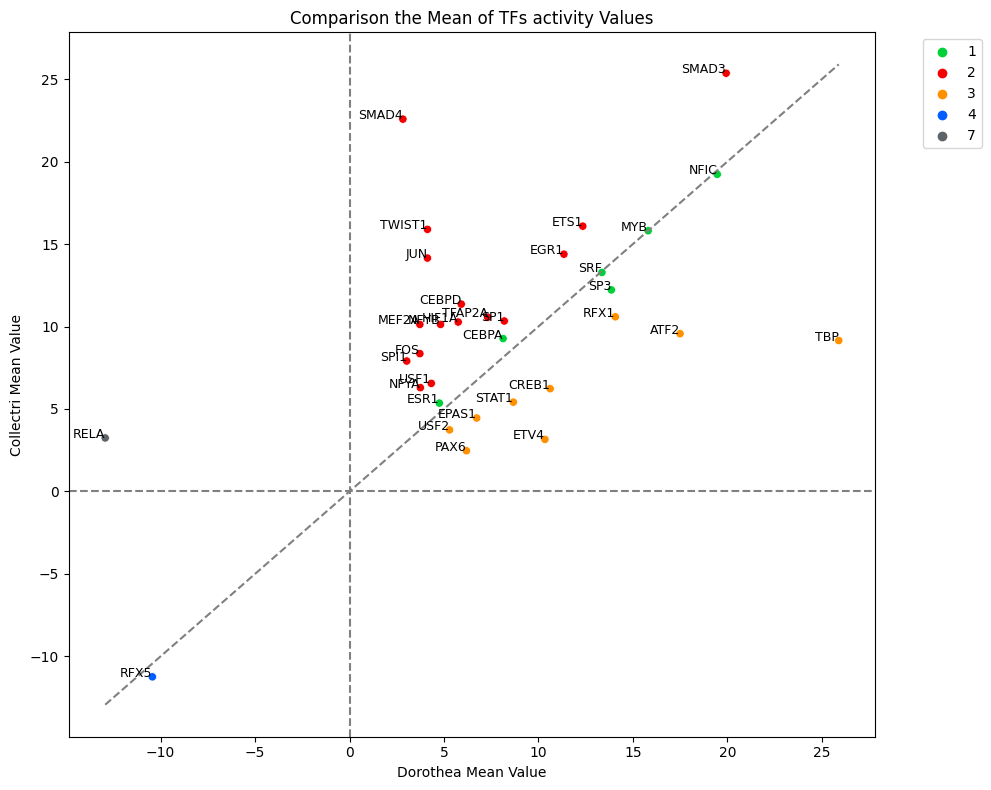

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="tf_group", palette=color_dict)
# sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="TF", palette=color_dict)
# Add TF names as text on the graph
for index, row in merged_result.iterrows():
    plt.text(row['tf_dorothea'], row['tf_collectri'], row['TF'], fontsize=9, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# 45-degree line
plt.plot([min(merged_result["tf_dorothea"].min(), merged_result["tf_collectri"].min()),
          max(merged_result["tf_dorothea"].max(), merged_result["tf_collectri"].max())],
         [min(merged_result["tf_dorothea"].min(), merged_result["tf_collectri"].min()),
          max(merged_result["tf_dorothea"].max(), merged_result["tf_collectri"].max())],
         color='gray', linestyle='--')
plt.title("Comparison the Mean of TFs activity Values")
plt.xlabel("Dorothea Mean Value")
plt.ylabel("Collectri Mean Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

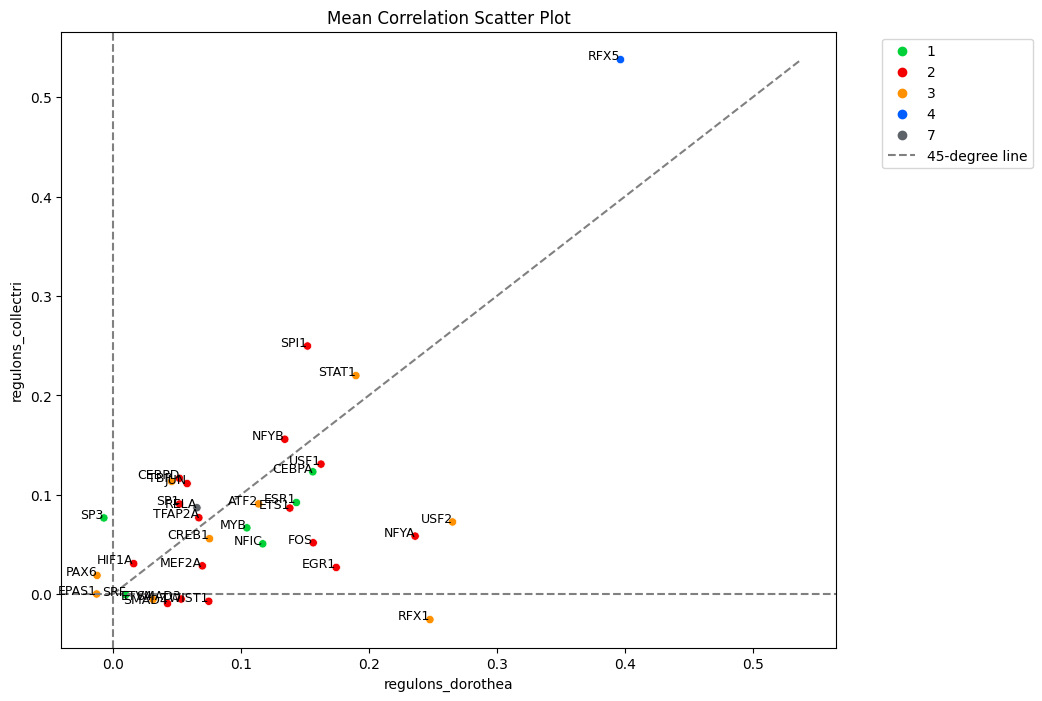

In [ ]:
# Plot the scatter
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_result, x="regulons_dorothea", y="regulons_collectri", hue="tf_group", palette=color_dict, legend="full")
# sns.scatterplot(data=merged_result, x="regulons_dorothea", y="regulons_collectri", hue="TF", palette=color_dict, legend="full")
# Add TF names as text on the graph
for index, row in merged_result.iterrows():
    plt.text(row['regulons_dorothea'], row['regulons_collectri'], row['TF'], fontsize=9, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# Adding the 45-degree line
max_val = max(merged_result["regulons_dorothea"].max(), merged_result["regulons_collectri"].max())
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label="45-degree line")
plt.title("Mean Correlation Scatter Plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


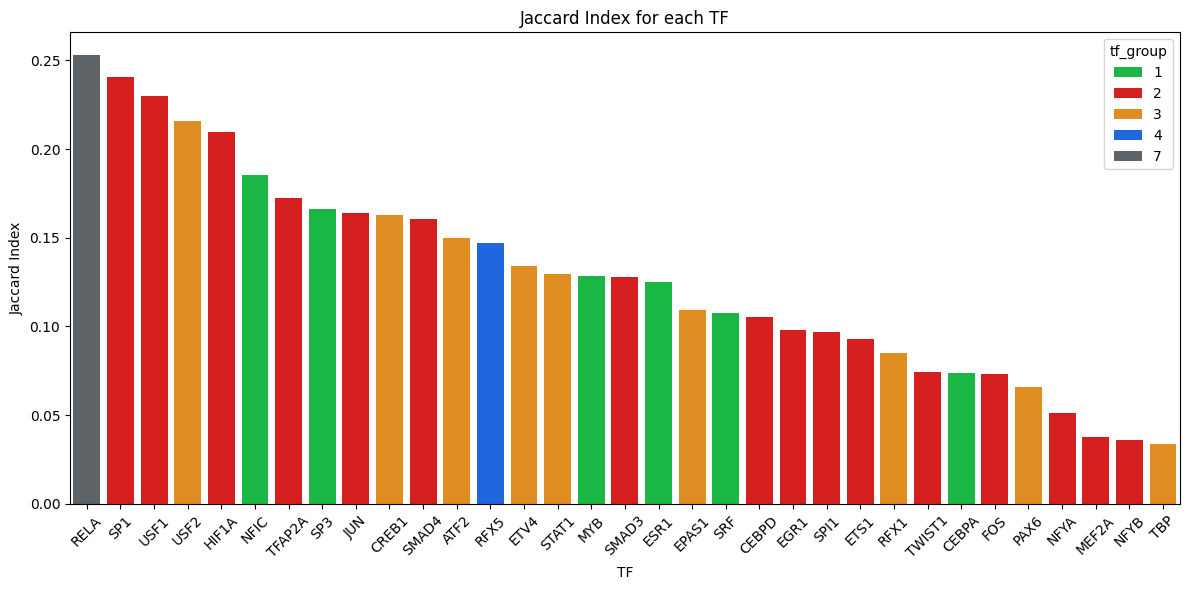

In [ ]:
# 8. Plot bar graph of Jaccard Indices
plt.figure(figsize=(12, 6))
sns.barplot(data=merged_result, x="TF", y="Jaccard Index", hue="tf_group", palette=color_dict, dodge=False)
plt.title("Jaccard Index for each TF")
plt.ylabel("Jaccard Index")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

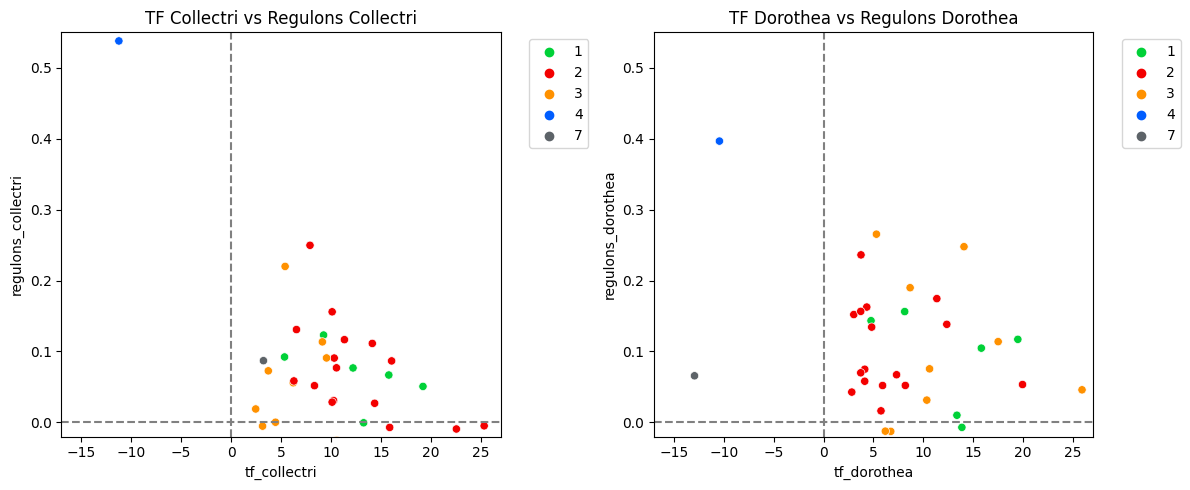

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Getting the limits for axes
lim = max(abs(merged_result[['tf_collectri', 'tf_dorothea', 'regulons_collectri', 'regulons_dorothea']].values.flatten()))

# Plot for tf_collectri vs regulons_collectri
sns.scatterplot(data=merged_result, x="tf_collectri", y="regulons_collectri",
                hue="tf_group", palette=color_dict, ax=axes[0]) # , style="marker", markers=marker_dict
# for index, row in merged_result.iterrows():
#     axes[0].text(row['tf_collectri'], row['regulons_collectri'], row['TF'], fontsize=9, ha='right')
axes[0].set_title("TF Collectri vs Regulons Collectri")
axes[0].legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].axvline(0, color='gray', linestyle='--')
axes[0].set_xlim(-17, 27)
axes[0].set_ylim(-0.02, 0.55)

# Plot for tf_dorothea vs regulons_dorothea
sns.scatterplot(data=merged_result, x="tf_dorothea", y="regulons_dorothea",
                hue="tf_group", palette=color_dict, ax=axes[1]) # , style="marker", markers=marker_dict
axes[1].set_title("TF Dorothea vs Regulons Dorothea")
axes[1].legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].axvline(0, color='gray', linestyle='--')
axes[1].set_xlim(-17, 27)
axes[1].set_ylim(-0.02, 0.55)

plt.tight_layout()
plt.show()


##### Set 241 TFs

In [ ]:

tf_lists = matched_columns.to_list()


# Placeholder for means
means = []

# Placeholder for Jaccard Index values
jaccard_indices = []

# Placeholder for Jaccard Index values
jaccard_regulons = []

# 1. Loop through each TF in tf_lists:
for tf in tf_lists:
    # # 2. Filtering to get the target column
    # regulons_collectri = collectri.loc[collectri['source'] == tf, 'target']
    # regulons_dorothea = dorothea.loc[dorothea['source'] == tf, 'target']

    # # 3. Filtering the 'mat' DataFrame
    # df_mat_collectri = mat[regulons_collectri[regulons_collectri.isin(mat.columns)].to_list()]
    # df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.isin(mat.columns)].to_list()]

    # # Convert the weight values
    # weights_sign_collectri = collectri.set_index('target').loc[regulons_collectri, 'weight'].apply(np.sign).to_dict()
    # weights_sign_dorothea = dorothea.set_index('target').loc[regulons_dorothea, 'weight'].apply(np.sign).to_dict()

    # Filtering to get the target column
    regulons_collectri = collectri.loc[collectri['source'] == tf, ['target','weight']]
    regulons_dorothea = dorothea.loc[dorothea['source'] == tf, ['target','weight']]

    # Filtering the 'mat' DataFrame
    df_mat_collectri = mat[regulons_collectri[regulons_collectri.target.isin(mat.columns)].target.to_list()]
    df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.target.isin(mat.columns)].target.to_list()]

    # Convert the weight values
    weights_sign_collectri = regulons_collectri.set_index('target').weight.apply(np.sign).to_dict()
    weights_sign_dorothea = regulons_dorothea.set_index('target').weight.apply(np.sign).to_dict()

    # Multiply the matrices by the sign of weight values
    for col in df_mat_collectri.columns:
        df_mat_collectri[col] *= weights_sign_collectri.get(col, 1)

    for col in df_mat_dorothea.columns:
        df_mat_dorothea[col] *= weights_sign_dorothea.get(col, 1)

    # Compute the intersection and union for collectri
    intersection_collectri = len(set(df_mat_collectri.columns).intersection(set(regulons_collectri['target'])))
    union_collectri = len(set(df_mat_collectri.columns).union(set(regulons_collectri['target'])))

    # Compute the intersection and union for dorothea
    intersection_dorothea = len(set(df_mat_dorothea.columns).intersection(set(regulons_dorothea['target'])))
    union_dorothea = len(set(df_mat_dorothea.columns).union(set(regulons_dorothea['target'])))

    # Calculate Jaccard Index for both databases
    jaccard_index_collectri = intersection_collectri / union_collectri if union_collectri != 0 else 0
    jaccard_index_dorothea = intersection_dorothea / union_dorothea if union_dorothea != 0 else 0

    jaccard_regulons.append([tf, jaccard_index_collectri, jaccard_index_dorothea])

    # 4. Compute the Pearson correlation
    correlation_collectri = df_mat_collectri.corr()
    correlation_dorothea = df_mat_dorothea.corr()

    # Sort the correlation matrices by the average correlation value
    sorted_columns_collectri = correlation_collectri.mean().sort_values(ascending=False).index
    sorted_columns_dorothea = correlation_dorothea.mean().sort_values(ascending=False).index

    correlation_collectri = correlation_collectri.loc[sorted_columns_collectri, sorted_columns_collectri]
    correlation_dorothea = correlation_dorothea.loc[sorted_columns_dorothea, sorted_columns_dorothea]

    # # Compute the intersection and union of the two regulons lists
    # intersection = len(set(regulons_collectri).intersection(set(regulons_dorothea)))
    # union = len(set(regulons_collectri).union(set(regulons_dorothea)))

    # # Calculate Jaccard Index
    # jaccard_index = intersection / union if union != 0 else 0
    # jaccard_indices.append([tf, jaccard_index])

    # Create sets for the targets in each regulon
    targets_collectri = set(regulons_collectri['target'])
    targets_dorothea = set(regulons_dorothea['target'])

    # Get targets that are present in both regulons
    shared_targets = targets_collectri.intersection(targets_dorothea)

    # Check for shared targets with same weight directions
    intersection_count = 0
    for target in shared_targets:
        weight_collectri = regulons_collectri.loc[regulons_collectri['target'] == target, 'weight'].values[0]
        weight_dorothea = regulons_dorothea.loc[regulons_dorothea['target'] == target, 'weight'].values[0]
        if np.sign(weight_collectri) == np.sign(weight_dorothea):
            intersection_count += 1

    # Compute the union by considering all distinct targets
    union_count = len(targets_collectri.union(targets_dorothea))

    # Calculate Jaccard Index
    jaccard_index = intersection_count / union_count if union_count != 0 else 0
    jaccard_indices.append([tf, jaccard_index])

    # Calculate the mean correlation and store
    # Extract upper triangle of the matrix (excluding the diagonal)
    upper_triangle_collectri = correlation_collectri.where(np.triu(np.ones(correlation_collectri.shape), k=1).astype(bool))
    # Compute the mean of the upper triangle values
    mean_collectri = upper_triangle_collectri.stack().mean()

    # Extract upper triangle of the matrix (excluding the diagonal)
    upper_triangle_dorothea = correlation_dorothea.where(np.triu(np.ones(correlation_dorothea.shape), k=1).astype(bool))
    # Compute the mean of the upper triangle values
    mean_dorothea = upper_triangle_dorothea.stack().mean()

    means.append([tf, mean_collectri, mean_dorothea])

    # # Plot correlation matrices
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # sns.heatmap(correlation_collectri, ax=ax1, cmap='coolwarm')
    # ax1.set_title(f"{tf} - Collectri (r={mean_collectri:.2f})")
    # sns.heatmap(correlation_dorothea, ax=ax2, cmap='coolwarm')
    # ax2.set_title(f"{tf} - Dorothea (r={mean_dorothea:.2f})")
    # plt.tight_layout()
    # plt.show()

print('Done.')

Done.


In [ ]:
# Convert means to DataFrame
correlation_mean = pd.DataFrame(means, columns=["TF", "regulons_collectri", "regulons_dorothea"])

# Convert Jaccard Regulons Indices to DataFrame
jaccard_df_regulons = pd.DataFrame(jaccard_regulons, columns=["TF", "Jaccard Collectri", "Jaccard Dorothea"])

# Convert Jaccard Indices to DataFrame
jaccard_df = pd.DataFrame(jaccard_indices, columns=["TF", "Jaccard Index"])

# Merge the correlation_mean and jaccard_df based on TF
merged_data = pd.merge(correlation_mean, jaccard_df, on='TF')
merged_data = pd.merge(merged_data, jaccard_df_regulons, on='TF')

# Calculate the mean of each column
mean_collectri = tf_collectri_acts.mean()
mean_dorothea = tf_dorothea_acts.mean()

# Find overlapping column names
overlap_columns = mean_collectri.index.intersection(mean_dorothea.index).tolist()

# Construct a new dataframe
result_df = pd.DataFrame({
    'TF': overlap_columns,
    'tf_collectri': mean_collectri[overlap_columns],
    'tf_dorothea': mean_dorothea[overlap_columns]
})

# Merge to get the sorting order from earlier data (based on Jaccard Index)
merged_result = result_df.reset_index(drop=True).merge(merged_data, on='TF', how='inner')

# Adding a new column for marker type based on the conditions provided
conditions = [
    (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] > 0),
    (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] < 0),
    (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] < 0),
    (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] > 0)
]

choices = ['o', 's', '^', 'v'] # circle, square, triangle_up, triangle_down

merged_result['marker'] = np.select(conditions, choices, default='o')

def classify_tf_group(row):
    tf_col = row['tf_collectri']
    tf_dor = row['tf_dorothea']

    if tf_col > 0 and tf_dor > 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 2
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
            return 3
        else:
            return 1
    elif tf_col < 0 and tf_dor < 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 5
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
            return 6
        else:
            return 4
    elif tf_col > 0 and tf_dor < 0:
        return 7
    elif tf_col < 0 and tf_dor > 0:
        return 8

merged_result['tf_group'] = merged_result.apply(classify_tf_group, axis=1)

# Find common TFs
common_tfs = tf_collectri_pvals.columns.intersection(tf_dorothea_pvals.columns)

# Filter the p-values for the common TFs
common_tf_collectri_pvals = tf_collectri_pvals[common_tfs]
common_tf_dorothea_pvals = tf_dorothea_pvals[common_tfs]

# Group the TFs based on the conditions provided:
matched_columns_1 = common_tfs[(common_tf_collectri_pvals < 0.05).all() & (common_tf_dorothea_pvals < 0.05).all()]
matched_columns_2 = common_tfs[(common_tf_collectri_pvals < 0.05).all() & (common_tf_dorothea_pvals >= 0.05).all()]
matched_columns_3 = common_tfs[(common_tf_collectri_pvals >= 0.05).all() & (common_tf_dorothea_pvals < 0.05).all()]
matched_columns_4 = common_tfs[(common_tf_collectri_pvals >= 0.05).all() & (common_tf_dorothea_pvals >= 0.05).all()]

# Group the TFs based on the conditions provided:
# matched_columns_1 = common_tfs[common_tf_collectri_pvals.lt(0.05).all() & common_tf_dorothea_pvals.lt(0.05).all()]
# matched_columns_2 = common_tfs[common_tf_collectri_pvals.lt(0.05).all() & common_tf_dorothea_pvals.gt(0.05).all()]
# matched_columns_3 = common_tfs[common_tf_collectri_pvals.gt(0.05).all() & common_tf_dorothea_pvals.lt(0.05).all()]
# matched_columns_4 = common_tfs[common_tf_collectri_pvals.gt(0.05).all() & common_tf_dorothea_pvals.gt(0.05).all()]

# Create a dictionary to map the column names to their corresponding markers
tf_to_marker = {}

# Populate the dictionary with the markers for each group
for tf in matched_columns_1:
    tf_to_marker[tf] = 'o'
for tf in matched_columns_2:
    tf_to_marker[tf] = '^'
for tf in matched_columns_3:
    tf_to_marker[tf] = 'v'
for tf in matched_columns_4:
    tf_to_marker[tf] = 's'

# Use the map function to update the 'tf_significant' column based on the 'TF' column
merged_result['tf_significant'] = merged_result['TF'].map(tf_to_marker).fillna("s")

# tf_lists_selected = matched_columns_filtered.to_list()
# merged_result['tf_significant'] = merged_result['TF'].apply(lambda x: 'o' if x in tf_lists_selected else '^')

# Sort the merged data by Jaccard Index in descending order
merged_result = merged_result.sort_values(by='Jaccard Index', ascending=False)

# # Create a colormap based on unique TFs
# cmap = sns.color_palette('hls', n_colors=len(merged_result['TF'].unique()))
# color_dict = dict(zip(merged_result['TF'].unique(), cmap))

# Create a colormap based on unique tf_group
# Green, Red, Orange, Blue, Purple, Pink, Dark Grey, Light Grey
cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]
color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))

# Create a dictionary that maps marker styles to their respective markers
marker_dict = {style: style for style in merged_result['tf_significant'].unique()}
marker_dict

merged_result.to_csv("merged_result_241.csv",index=False)
merged_result

TF  tf_collectri  tf_dorothea  regulons_collectri  regulons_dorothea  \
126     MYC      1.929774     4.190561            0.074771           0.134906   
139   NFKB1      0.286096   -11.897500            0.110531           0.173820   
203   STAT4     -0.066540     0.116216            0.203497           0.060989   
171    RELA      3.242743   -12.932334            0.087019           0.065716   
66    FOXO4      2.275198     0.735606            0.436830           0.333672   
..      ...           ...          ...                 ...                ...   
123    MXI1     -0.073494     2.089622            0.250209           0.096031   
130   NCOA1      2.500055     0.253237           -0.013581           0.227171   
136  NFE2L1      0.379169     2.273049            0.144652           0.348702   
145   NR2C2      1.599420     0.011807            0.053952           0.309267   
240  ZNF384     17.343679     0.955470           -0.001777           0.097255   

     Jaccard Index  Jaccard Collectri  Jaccard Dorothea marker  tf_group  \
126       0.395855           0.789414          0.864516      o         3   
139       0.332681           0.568129          0.684000      ^         7   
203       0.285714           0.375000          0.692308      v         8   
171       0.253145           0.592527          0.736626      ^         7   
66        0.243243           0.645161          0.733333      o         2   
..             ...                ...               ...    ...       ...   
123       0.000000           0.888889          0.922078      v         8   
130       0.000000           0.571429          1.000000      o         2   
136       0.000000           0.555556          0.870968      o         3   
145       0.000000           0.633333          0.931818      o         2   
240       0.000000           0.560000          0.939394      o         2   

    tf_significant  
126              s  
139              s  
203              s  
171              o  
66               ^  
..             ...  
123              s  
130              ^  
136              s  
145              s  
240              ^  

[241 rows x 11 columns]

In [ ]:
merged_result_myselected = merged_result.loc[merged_result.TF.isin(["RUNX2","GATA3","RFX5","IRF1","IKZF1","RELA","SMAD4","TBP","MYB"]),].sort_values(by="tf_group")
merged_result_myselected.to_csv("merged_result_myselected.csv",index=False)

merged_result_myselected

TF  tf_collectri  tf_dorothea  regulons_collectri  regulons_dorothea  \
124    MYB     15.804016    15.806473            0.066819           0.104715   
183  SMAD4     22.575455     2.824253           -0.009303           0.042733   
177  RUNX2     22.453857     1.065732           -0.001358           0.090935   
72   GATA3      0.744254     7.668066            0.124960           0.129002   
208    TBP      9.147180    25.895605            0.113551           0.045927   
175   RFX5    -11.243306   -10.435596            0.537853           0.396649   
88    IRF1     -4.083889    -0.149805            0.402418           0.306347   
87   IKZF1     -0.228279    -0.304322           -0.055937           0.312874   
171   RELA      3.242743   -12.932334            0.087019           0.065716   

     Jaccard Index  Jaccard Collectri  Jaccard Dorothea marker  tf_group  \
124       0.128440           0.617486          0.615385      o         1   
183       0.160428           0.605634          0.818182      o         2   
177       0.021164           0.604651          0.923077      o         2   
72        0.074807           0.551546          0.724841      o         3   
208       0.033981           0.694611          0.891304      o         3   
175       0.147059           0.461538          0.824176      s         4   
88        0.183099           0.558824          0.722892      s         5   
87        0.000000           0.326923          0.825000      s         6   
171       0.253145           0.592527          0.736626      ^         7   

    tf_significant  
124              o  
183              o  
177              ^  
72               v  
208              o  
175              o  
88               ^  
87               s  
171              o

In [ ]:
print(matched_columns_1.shape[0],
      matched_columns_2.shape[0],
      matched_columns_3.shape[0],
      matched_columns_4.shape[0],
      matched_columns_1.shape[0]+
      matched_columns_2.shape[0]+
      matched_columns_3.shape[0]+
      matched_columns_4.shape[0])

33 32 9 71 145


In [ ]:
merged_result['tf_group'].value_counts().sort_index()

1    17
2    97
3    61
4     2
5     5
6     5
7    21
8    33
Name: tf_group, dtype: int64

In [ ]:
merged_result['tf_significant'].value_counts().sort_index()

^     32
o     33
s    167
v      9
Name: tf_significant, dtype: int64

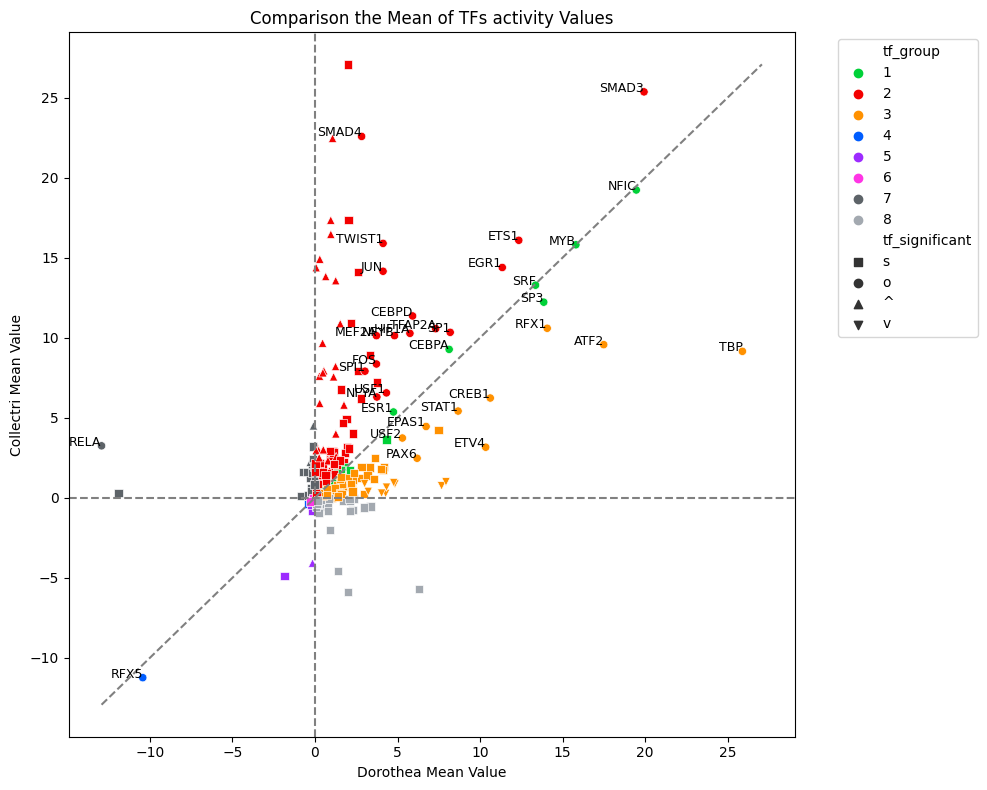

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="tf_group",
                palette=color_dict, style="tf_significant", markers=marker_dict)
# sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="TF", palette=color_dict)
# Add TF names as text on the graph
for index, row in merged_result.iterrows():
    if row['tf_significant'] == "o":
        plt.text(row['tf_dorothea'], row['tf_collectri'], row['TF'], fontsize=9, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# 45-degree line
plt.plot([min(merged_result["tf_dorothea"].min(), merged_result["tf_collectri"].min()),
          max(merged_result["tf_dorothea"].max(), merged_result["tf_collectri"].max())],
         [min(merged_result["tf_dorothea"].min(), merged_result["tf_collectri"].min()),
          max(merged_result["tf_dorothea"].max(), merged_result["tf_collectri"].max())],
         color='gray', linestyle='--')
plt.title("Comparison the Mean of TFs activity Values")
plt.xlabel("Dorothea Mean Value")
plt.ylabel("Collectri Mean Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

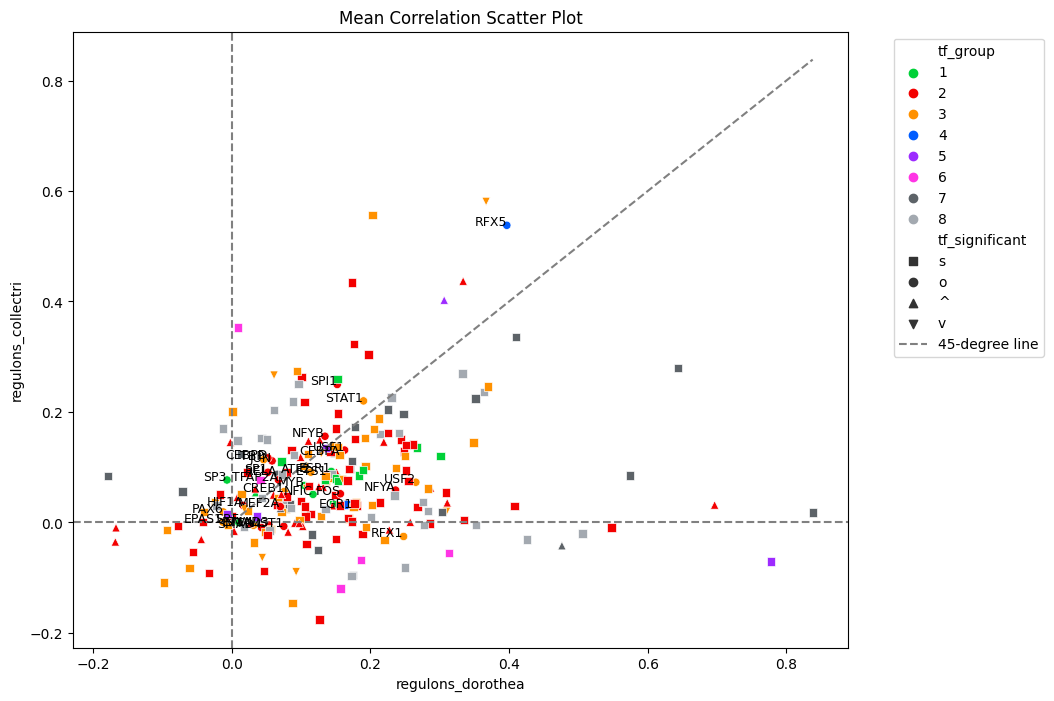

In [ ]:
# Plot the scatter
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_result, x="regulons_dorothea", y="regulons_collectri", hue="tf_group",
                palette=color_dict, legend="full", style="tf_significant", markers=marker_dict)
# sns.scatterplot(data=merged_result, x="regulons_dorothea", y="regulons_collectri", hue="TF", palette=color_dict, legend="full")
# Add TF names as text on the graph
for index, row in merged_result.iterrows():
  if row['tf_significant'] == "o":
    plt.text(row['regulons_dorothea'], row['regulons_collectri'], row['TF'], fontsize=9, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# Adding the 45-degree line
max_val = max(merged_result["regulons_dorothea"].max(), merged_result["regulons_collectri"].max())
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label="45-degree line")
plt.title("Mean Correlation Scatter Plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


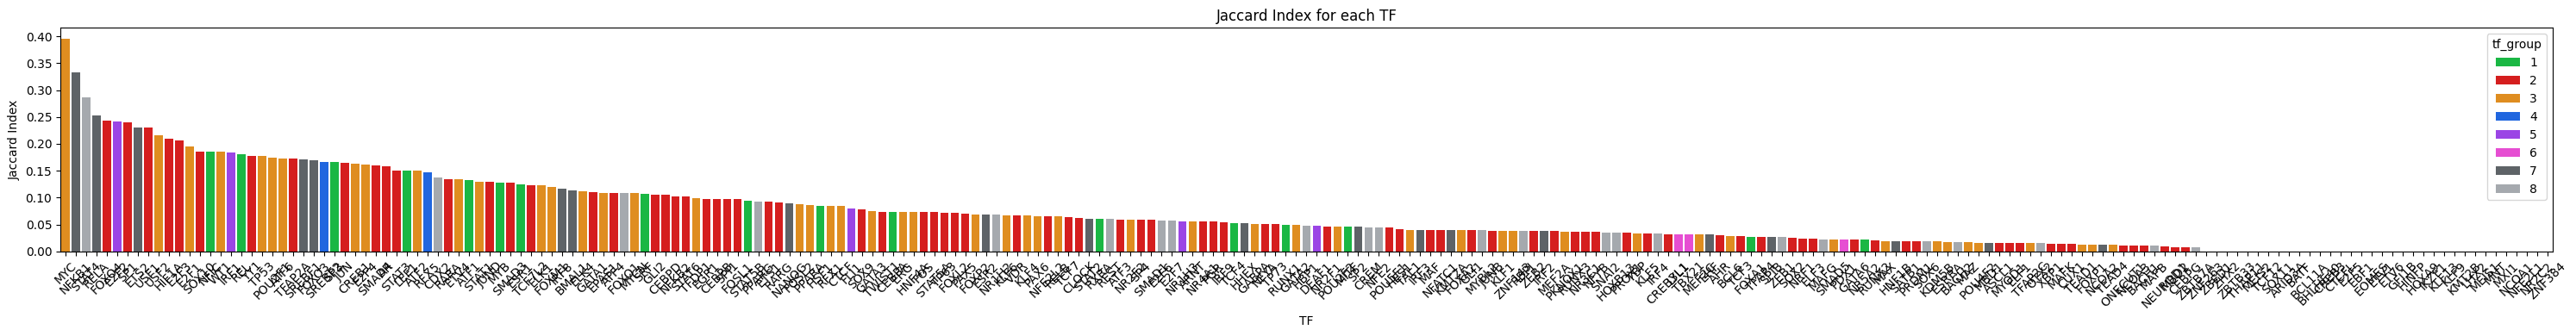

In [ ]:
# 8. Plot bar graph of Jaccard Indices
plt.figure(figsize=(30, 4))
sns.barplot(data=merged_result, x="TF", y="Jaccard Index", hue="tf_group",
            palette=color_dict, dodge=False)
plt.title("Jaccard Index for each TF")
plt.ylabel("Jaccard Index")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

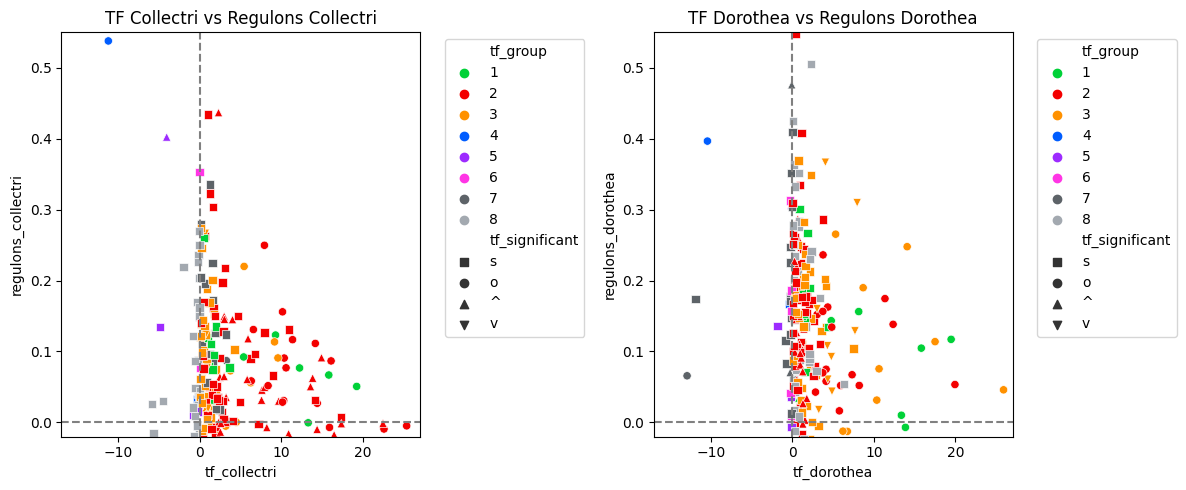

In [ ]:
# Plot the scatter
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Getting the limits for axes
lim = max(abs(merged_result[['tf_collectri', 'tf_dorothea', 'regulons_collectri', 'regulons_dorothea']].values.flatten()))

# Plot for tf_collectri vs regulons_collectri
sns.scatterplot(data=merged_result, x="tf_collectri", y="regulons_collectri",
                hue="tf_group", palette=color_dict, style="tf_significant", markers=marker_dict, ax=axes[0]) # , style="marker", markers=marker_dict
axes[0].set_title("TF Collectri vs Regulons Collectri")
axes[0].legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].axvline(0, color='gray', linestyle='--')
axes[0].set_xlim(-17, 27)
axes[0].set_ylim(-0.02, 0.55)

# Plot for tf_dorothea vs regulons_dorothea
sns.scatterplot(data=merged_result, x="tf_dorothea", y="regulons_dorothea",
                hue="tf_group", palette=color_dict, style="tf_significant", markers=marker_dict, ax=axes[1]) # , style="marker", markers=marker_dict
axes[1].set_title("TF Dorothea vs Regulons Dorothea")
axes[1].legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].axvline(0, color='gray', linestyle='--')
axes[1].set_xlim(-17, 27)
axes[1].set_ylim(-0.02, 0.55)

plt.tight_layout()
plt.show()


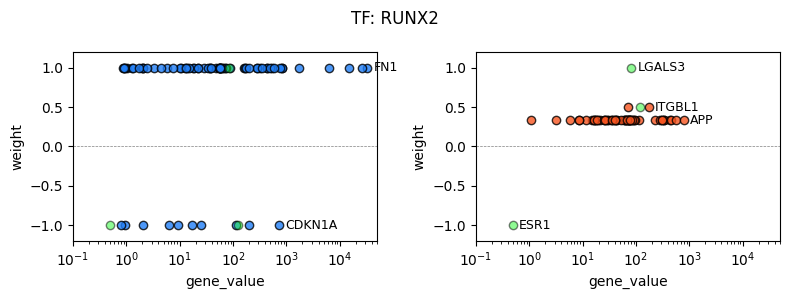

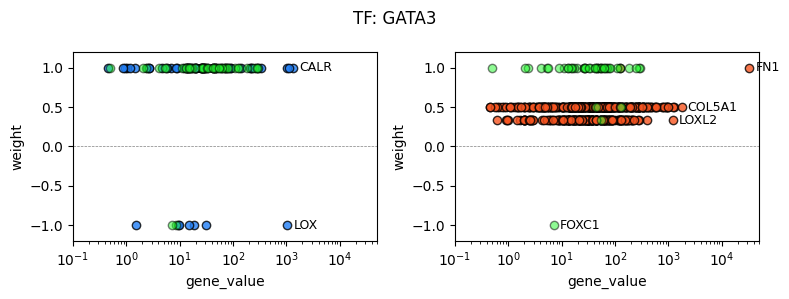

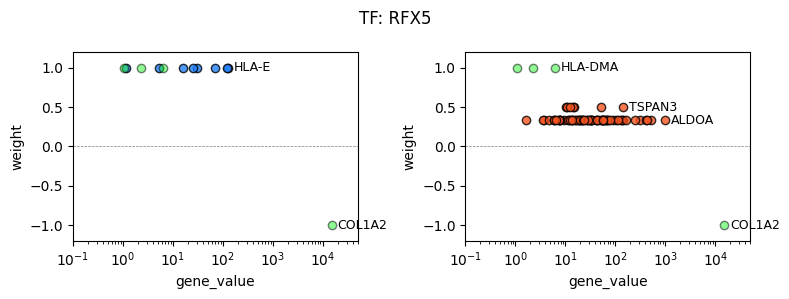

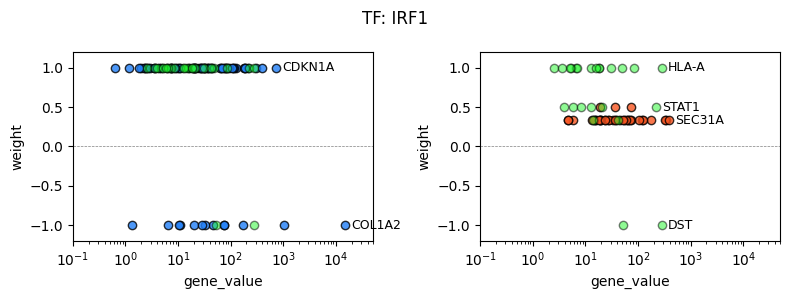

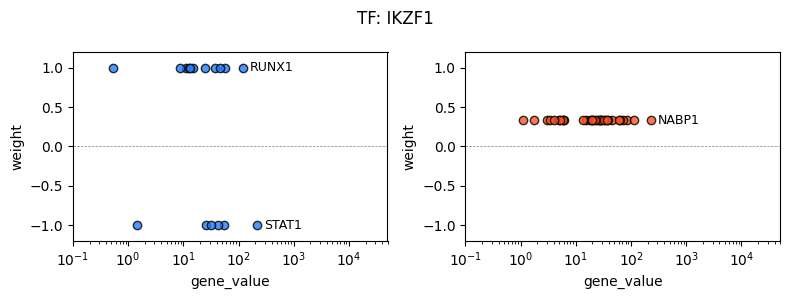

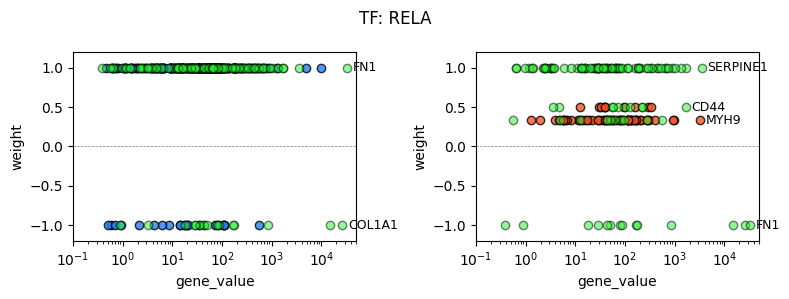

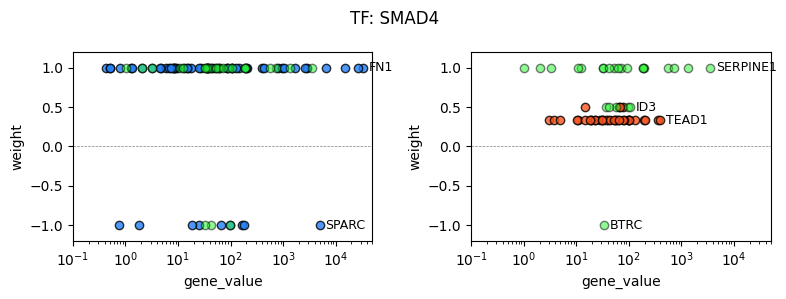

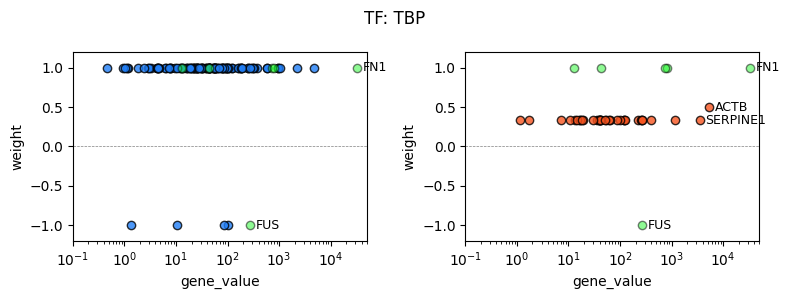

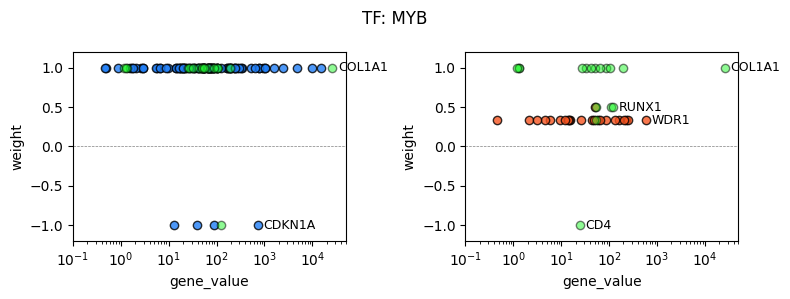

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

matched_columns_filtered_selected = ["RUNX2", "GATA3", "RFX5", "IRF1", "IKZF1", "RELA", "SMAD4", "TBP", "MYB"]

for select_tf in matched_columns_filtered_selected:
    # 1. Get regulons with "weight" for both databases
    collectri_selected = collectri[collectri['source'] == select_tf]
    dorothea_selected = dorothea[dorothea['source'] == select_tf]

    # 2. Combine the dataframe "mat" mean values
    select_mat_collectri = collectri_selected[['target', 'weight']].copy()
    select_mat_collectri['gene_value'] = select_mat_collectri['target'].map(mat.mean())

    select_mat_dorothea = dorothea_selected[['target', 'weight']].copy()
    select_mat_dorothea['gene_value'] = select_mat_dorothea['target'].map(mat.mean())

    # 3. Find the overlap name of regulons for coloring
    overlap_targets = set(collectri_selected['target']) & set(dorothea_selected['target'])
    select_mat_collectri_overlap = select_mat_collectri[select_mat_collectri['target'].isin(overlap_targets)]
    select_mat_dorothea_overlap = select_mat_dorothea[select_mat_dorothea['target'].isin(overlap_targets)]

    # Exclude overlapping data for clear visualization
    select_mat_collectri_excluded = select_mat_collectri.copy()[~select_mat_collectri['target'].isin(overlap_targets)]
    select_mat_dorothea_excluded = select_mat_dorothea.copy()[~select_mat_dorothea['target'].isin(overlap_targets)]

    # 4. Plot the scatter between gene values and weight
    # Create a scatter plot
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    fig.suptitle(f'TF: {select_tf}')

    # Function to annotate highest gene_value for each unique weight
    def annotate_highest_gene_value(data, ax):
        for _, group in data.groupby('weight'):
            idx_max = group['gene_value'].idxmax()
            highest_row = group.loc[idx_max]
            ax.text(highest_row['gene_value'] * 1.3, highest_row['weight'], highest_row['target'], ha='left', va='center', fontsize=9)

    # Plot for collectri
    sns.scatterplot(ax=axes[0],
                    x="gene_value",
                    y="weight",
                    data=select_mat_collectri_excluded,
                    color="#217FF7",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth=1,
                    alpha=0.8)
    sns.scatterplot(ax=axes[0],
                    x="gene_value",
                    y="weight",
                    data=select_mat_collectri_overlap,
                    color="#21f72b",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth=1,
                    alpha=0.5)
    annotate_highest_gene_value(select_mat_collectri, axes[0])

    # Plot for dorothea
    sns.scatterplot(ax=axes[1],
                    x="gene_value",
                    y="weight",
                    data=select_mat_dorothea_excluded,
                    color="#f75521",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth=1,
                    alpha=0.8)
    sns.scatterplot(ax=axes[1],
                    x="gene_value",
                    y="weight",
                    data=select_mat_dorothea_overlap,
                    color="#21f72b",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth=1,
                    alpha=0.5)
    annotate_highest_gene_value(select_mat_dorothea, axes[1])

    # 5. Draw the origin horizontal and vertical line
    for ax in axes:
        ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
        ax.set_xscale('log')
        ax.set_xlim([1e-1, 5e4])
        ax.set_ylim([-1.2, 1.2])

    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np

# Dataset 1
x1 = np.array([0.1, 90, 100])
y1 = np.array([-1, 1, 1])

# Dataset 2
x2 = np.array([0.5, 9, 10])
y2 = np.array([-1, 1, 1])

# Linear regression for Dataset 1
slope1 = np.sum((x1 - x1.mean()) * (y1 - y1.mean())) / np.sum((x1 - x1.mean())**2)
y_pred1 = slope1 * x1 + (y1.mean() - slope1 * x1.mean())
residuals1 = y1 - y_pred1
SE_slope1 = np.sqrt(np.sum(residuals1**2) / (len(x1) - 2) / np.sum((x1 - x1.mean())**2))
t_value1 = slope1 / SE_slope1

# Linear regression for Dataset 2
slope2 = np.sum((x2 - x2.mean()) * (y2 - y2.mean())) / np.sum((x2 - x2.mean())**2)
y_pred2 = slope2 * x2 + (y2.mean() - slope2 * x2.mean())
residuals2 = y2 - y_pred2
SE_slope2 = np.sqrt(np.sum(residuals2**2) / (len(x2) - 2) / np.sum((x2 - x2.mean())**2))
t_value2 = slope2 / SE_slope2

t_value1, t_value2


(10.958108109219095, 10.392304845413259)

In [ ]:
 filtered_dorothea = dorothea.loc[dorothea.source.isin(["RTX5"])]
 filtered_dorothea = filtered_dorothea.loc[filtered_dorothea.target.isin(mat.columns.to_list())]
 filtered_dorothea

source confidence    target    weight
207     ATF2          A      PCK2  1.000000
208     ATF2          A    IMPDH2  1.000000
764     ATF2          A       RB1  1.000000
1027    ATF2          A     TGFB2 -1.000000
2996    ATF2          A       FOS  1.000000
4213    ATF2          A       JUN  1.000000
4271    ATF2          A      PLAT  1.000000
4554    ATF2          A     NR4A2  1.000000
4581    ATF2          A     PTGS2  1.000000
4674    ATF2          A      ATF3  1.000000
4686    ATF2          A    CDKN1A  1.000000
5171    ATF2          A     DUSP1  1.000000
5195    ATF2          A     CCND1  1.000000
5769    ATF2          A      MMP2  1.000000
5866    ATF2          A       FN1  1.000000
12626   ATF2          B    DUSP10  0.500000
14640   ATF2          B      BCL2  0.500000
22173   ATF2          C     PSIP1  0.333333
22174   ATF2          C      OXR1  0.333333
22175   ATF2          C      NUMB  0.333333
22176   ATF2          C     NCOA7  0.333333
22178   ATF2          C      MSI2  0.333333
22180   ATF2          C     MBNL1  0.333333
22181   ATF2          C      LYST  0.333333
22182   ATF2          C  KIAA1217  0.333333
22183   ATF2          C     HMGB1  0.333333
22184   ATF2          C     GTDC1  0.333333
22185   ATF2          C      GNG2  0.333333
22194   ATF2          C    ARID1A  0.333333
22199   ATF2          C     CDK14  0.333333
22200   ATF2          C     DMTF1  0.333333
22201   ATF2          C    FNDC3B  0.333333
22202   ATF2          C     FOXP1  0.333333
22203   ATF2          C      GNAS  0.333333
22204   ATF2          C     AZIN1  0.333333
22275   ATF2          C      PTK2  0.333333
22909   ATF2          C    ZCCHC7  0.333333
22911   ATF2          C    ZBTB38  0.333333
22912   ATF2          C     USP9X  0.333333
22914   ATF2          C     UBE2H  0.333333
22916   ATF2          C    UBE2E1  0.333333
22917   ATF2          C       UBC  0.333333
22918   ATF2          C     THADA  0.333333
22919   ATF2          C     TERF1  0.333333
22922   ATF2          C     TEAD1  0.333333
22923   ATF2          C      TCF4  0.333333
22924   ATF2          C     TCF12  0.333333
22925   ATF2          C     RAB12  0.333333
22926   ATF2          C  RABGAP1L  0.333333
22927   ATF2          C      RBPJ  0.333333
22930   ATF2          C     RPS29  0.333333
22933   ATF2          C  SLC39A10  0.333333
22934   ATF2          C      SND1  0.333333
22937   ATF2          C     STAT1  0.333333
22938   ATF2          C   TBL1XR1  0.333333
22939   ATF2          C     SGMS1  0.333333
22941   ATF2          C    ZNF462  0.333333

In [ ]:
filtered_mat_dorothea = mat[filtered_dorothea.target.to_list()]
filtered_mat_dorothea

GeneName            PCK2      IMPDH2        RB1      TGFB2       FOS  \
25_HSCs-Ctrl1  32.950184  123.262924  70.338982  55.691551  0.678847   
26_HSCs-Ctrl2  40.605511  123.543999  73.854065  47.027603  0.609692   
27_HSCs-Ctrl3  42.939037  119.722389  66.719513  51.921944  0.596376   
31_HSCs-TGFb1  62.179428  107.535728  88.889053  79.699799  1.465990   
32_HSCs-TGFb2  61.955616  105.835983  91.684036  88.834969  1.681419   
33_HSCs-TGFb3  61.071396   94.258583  91.146507  92.042786  1.593383   

GeneName              JUN        PLAT      NR4A2      PTGS2      ATF3  ...  \
25_HSCs-Ctrl1  111.983620  275.794586  32.062458   2.845935  6.631812  ...   
26_HSCs-Ctrl2  117.020287  352.524139  21.786341   3.739446  4.857216  ...   
27_HSCs-Ctrl3  127.661636  358.999420  21.879526   3.522343  6.075576  ...   
31_HSCs-TGFb1   69.992081   61.124630   2.359886  34.289864  2.896224  ...   
32_HSCs-TGFb2   65.388512   69.195061   1.985008  46.682728  2.218539  ...   
33_HSCs-TGFb3   68.266518   66.324585   2.838214  39.361549  2.539455  ...   

GeneName           RAB12   RABGAP1L        RBPJ       RPS29   SLC39A10  \
25_HSCs-Ctrl1  39.712540  14.046908  213.184021  205.560059  56.918697   
26_HSCs-Ctrl2  36.134434  14.307447  211.095825  182.623184  63.306389   
27_HSCs-Ctrl3  34.384777  13.176171  182.341812  184.764587  54.754726   
31_HSCs-TGFb1  35.827366  11.513385  159.739273  162.295822  32.913261   
32_HSCs-TGFb2  42.058826  13.311234  179.678299  159.851562  36.057095   
33_HSCs-TGFb3  39.660309  13.493965  193.645874  162.151657  37.120853   

GeneName             SND1       STAT1     TBL1XR1      SGMS1     ZNF462  
25_HSCs-Ctrl1  266.081848  334.906494  159.711777  34.647301  20.469843  
26_HSCs-Ctrl2  286.657013  317.141632  155.938980  30.078157  18.067217  
27_HSCs-Ctrl3  292.056274  320.253662  128.854385  31.999275  16.400328  
31_HSCs-TGFb1  260.892578  112.380646   71.511703  14.427486  13.086642  
32_HSCs-TGFb2  257.373871  118.399918   85.939186  17.351309  12.797466  
33_HSCs-TGFb3  235.447281  118.781746   90.773056  16.083214  15.012659  

[6 rows x 57 columns]

In [ ]:
# Calculate correlations with "ATF2_collectri"
correlation_with_collectri = filtered_mat_collectri.corrwith(df_merged_filtered_selected["ATF2_collectri"])

# Calculate correlations with "ATF2_dorothea"
correlation_with_dorothea = filtered_mat_dorothea.corrwith(df_merged_filtered_selected["ATF2_dorothea"])

# Combine the results into a DataFrame for better visualization and comparison
correlation_comparison = pd.DataFrame({
    'Correlation_with_Collectri': correlation_with_collectri,
    'Correlation_with_Dorothea': correlation_with_dorothea
})

correlation_comparison

Correlation_with_Collectri  Correlation_with_Dorothea
GeneName                                                       
ACE                        -0.951613                        NaN
APEX1                      -0.986279                        NaN
ARID1A                           NaN                  -0.971833
ATF2                        0.445628                        NaN
ATF3                       -0.964827                  -0.966682
...                              ...                        ...
USP9X                            NaN                  -0.686316
YTHDC2                     -0.905185                        NaN
ZBTB38                           NaN                   0.966796
ZCCHC7                           NaN                   0.579747
ZNF462                           NaN                  -0.854898

[121 rows x 2 columns]

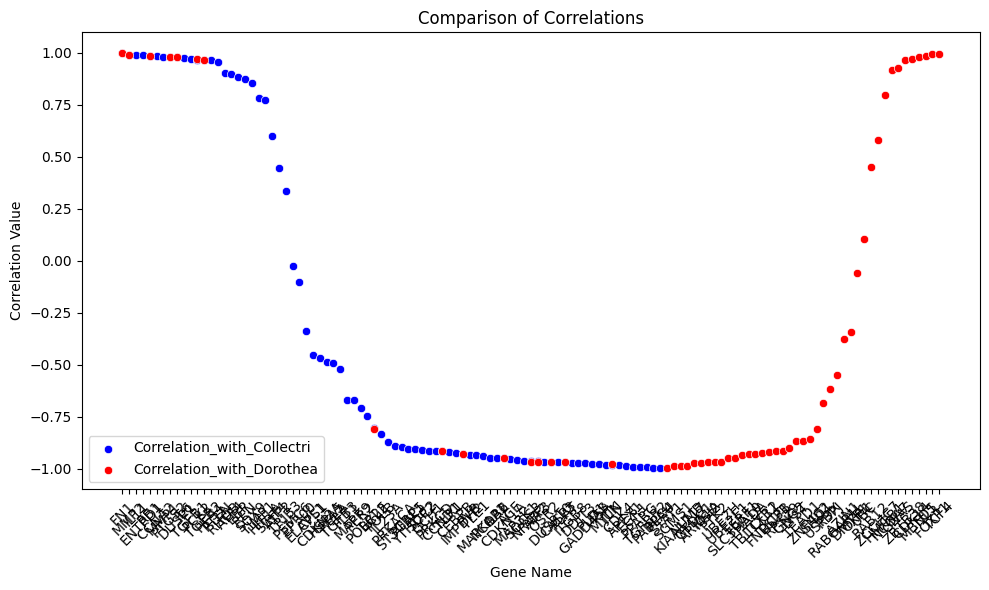

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by 'Correlation_with_Collectri'
correlation_comparison_sorted = correlation_comparison.sort_values(by='Correlation_with_Dorothea', ascending=True)
correlation_comparison_sorted = correlation_comparison_sorted.sort_values(by='Correlation_with_Collectri', ascending=False)

# Generate an ordered index for x-axis
correlation_comparison_sorted['Gene_Rank'] = range(1, len(correlation_comparison_sorted) + 1)

plt.figure(figsize=(10, 6))

# Scatter plot for 'Correlation_with_Collectri'
sns.scatterplot(x='Gene_Rank',
                y='Correlation_with_Collectri',
                data=correlation_comparison_sorted,
                color='blue',
                label='Correlation_with_Collectri')

# Scatter plot for 'Correlation_with_Dorothea'
sns.scatterplot(x='Gene_Rank',
                y='Correlation_with_Dorothea',
                data=correlation_comparison_sorted,
                color='red',
                label='Correlation_with_Dorothea')

# Setting xticks to be gene names for better clarity
plt.xticks(correlation_comparison_sorted['Gene_Rank'], correlation_comparison_sorted.index, rotation=45)
plt.ylabel('Correlation Value')
plt.xlabel('Gene Name')
plt.title('Comparison of Correlations')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Find common columns
matched_columns = tf_collectri_acts.columns.intersection(tf_dorothea_acts.columns)

# Merge two dataframes based on the matched columns
df_merged = pd.merge(tf_collectri_acts[matched_columns], tf_dorothea_acts[matched_columns], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

df_merged_mean = pd.concat([df_merged.iloc[0:3,].mean(),df_merged.iloc[3:6,].mean()], axis = 1).T.rename(index={0:"control",1:"treatment"})
df_merged_mean

AHR_collectri  AR_collectri  ARID3A_collectri  ARNT_collectri  \
control         3.459154      7.221019          0.800605        1.148278   
treatment       2.538044      8.587142          0.288810        1.419675   

           ASCL1_collectri  ATF1_collectri  ATF2_collectri  ATF3_collectri  \
control           2.625024        2.585873        6.307606        5.816425   
treatment         1.741647       -0.170205       12.820328       13.503880   

           ATF4_collectri  ATF6_collectri  ...  YY1_dorothea  ZBED1_dorothea  \
control          3.477003        2.447046  ...      0.161761        0.747967   
treatment        1.346324        1.339911  ...      0.384181        0.162143   

           ZBTB33_dorothea  ZBTB7A_dorothea  ZEB1_dorothea  ZEB2_dorothea  \
control           1.157385         3.352445       7.367555       5.220081   
treatment         0.404810         1.196622       5.209786       2.260386   

           ZHX2_dorothea  ZNF143_dorothea  ZNF263_dorothea  ZNF384_dorothea  
control         1.031183         1.004166         2.339644          1.36603  
treatment       0.283522         0.361718         0.861336          0.54491  

[2 rows x 482 columns]

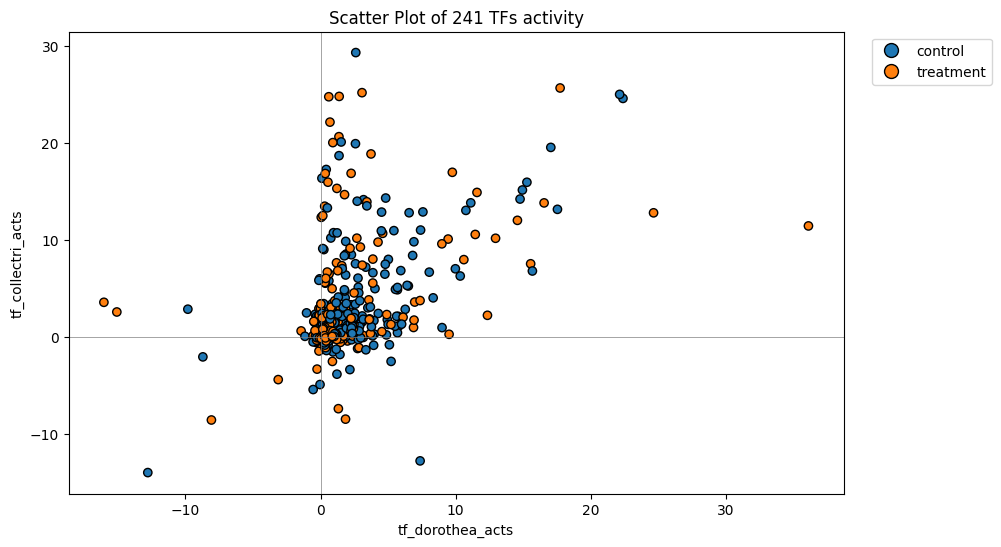

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

color2 = sns.color_palette(None, 2)

for col in matched_columns:
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_mean,
                    hue=[0,1],
                    palette=color2,
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)

# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=color2[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(df_merged_mean.index.to_list())]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlabel('tf_dorothea_acts')
plt.ylabel('tf_collectri_acts')
plt.title(f'Scatter Plot of {len(matched_columns)} TFs activity')
plt.show()

In [ ]:
# Find common columns
matched_columns_filtered = tf_collectri_acts_filtered.columns.intersection(tf_dorothea_acts_filtered.columns)

# Merge two dataframes based on the matched columns
df_merged_filtered = pd.merge(tf_collectri_acts_filtered[matched_columns_filtered], tf_dorothea_acts_filtered[matched_columns_filtered], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

df_merged_filtered_mean = pd.concat([df_merged_filtered.iloc[0:3,].mean(),df_merged_filtered.iloc[3:6,].mean()], axis = 1).T.rename(index={0:"control",1:"treatment"})
df_merged_filtered_mean

ATF2_collectri  CEBPA_collectri  CEBPD_collectri  CREB1_collectri  \
control          6.307606         8.421707        12.912441         4.889843   
treatment       12.820328        10.116340         9.801749         7.568696   

           EGR1_collectri  EPAS1_collectri  ESR1_collectri  ETS1_collectri  \
control         13.848778         5.280023        6.865137       15.174264   
treatment       14.923134         3.623824        3.849170       16.996002   

           ETV4_collectri  FOS_collectri  ...  SP1_dorothea  SP3_dorothea  \
control          4.055309       6.502291  ...      7.403031     14.765106   
treatment        2.257694      10.207952  ...      8.978395     12.951866   

           SPI1_dorothea  SRF_dorothea  STAT1_dorothea  TBP_dorothea  \
control         3.871781     15.272679        9.976930     15.678473   
treatment       2.182137     11.449157        7.363917     36.112732   

           TFAP2A_dorothea  TWIST1_dorothea  USF1_dorothea  USF2_dorothea  
control          10.756615         4.516359       4.790402       5.691009  
treatment         3.869361         3.732575       3.863482       4.896845  

[2 rows x 66 columns]

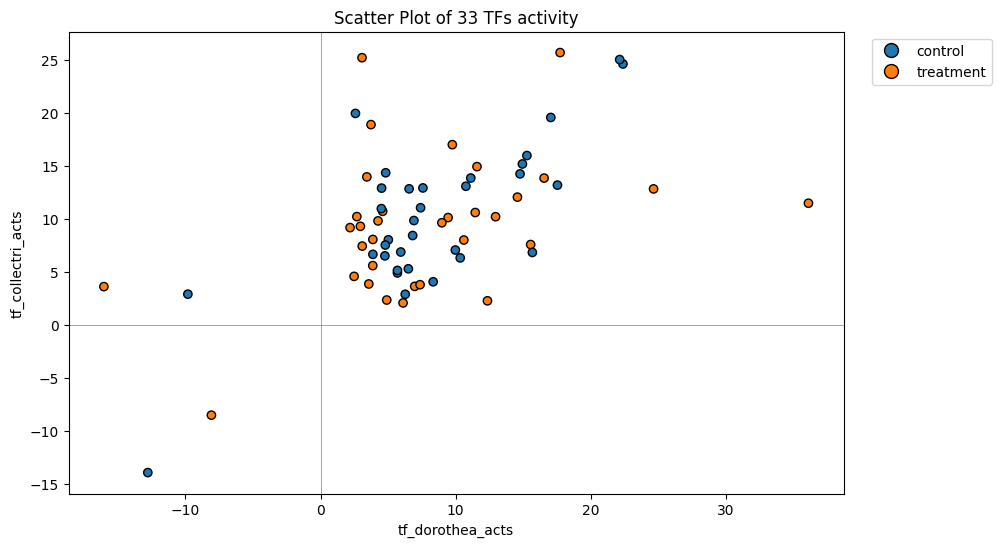

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

color2 = sns.color_palette(None, 2)

for col in matched_columns_filtered:
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean,
                    hue=[0,1],
                    palette=color2,
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)

# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=color2[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(df_merged_filtered_mean.index.to_list())]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlabel('tf_dorothea_acts')
plt.ylabel('tf_collectri_acts')
plt.title(f'Scatter Plot of {len(matched_columns_filtered)} TFs activity')
plt.show()

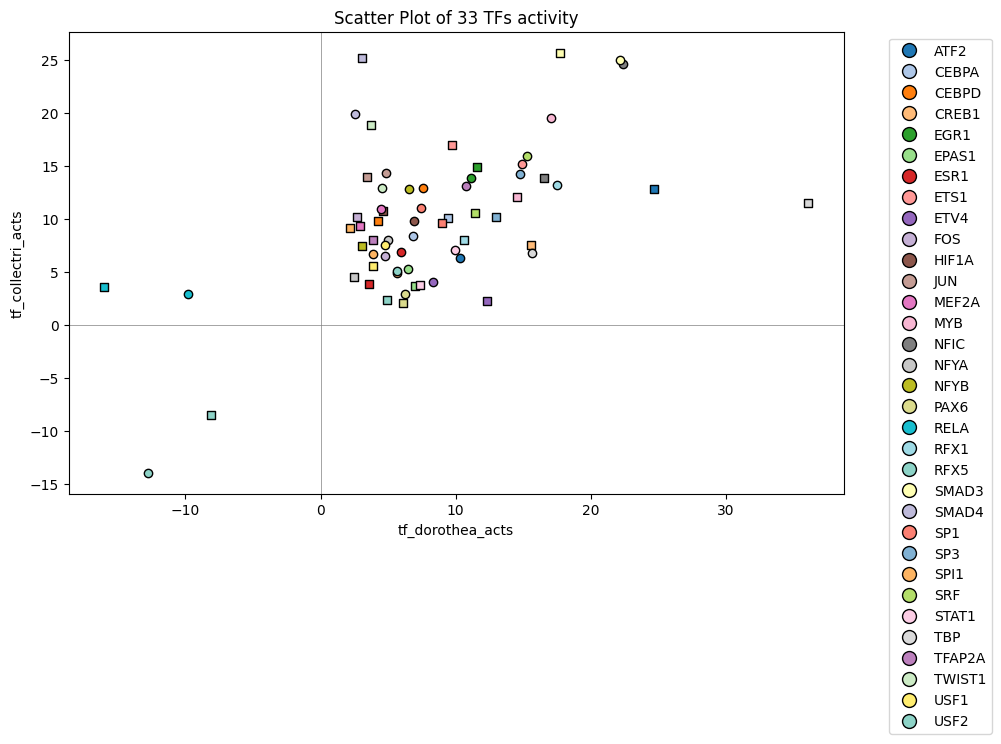

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Combine the 'tab20' and 'Set3' palettes
colors = sns.color_palette('tab20', 20) + sns.color_palette('Set3', 13)

for i, col in enumerate(matched_columns_filtered):
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean.iloc[[0]],
                    color=colors[i],
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean.iloc[[1]],
                    color=colors[i],
                    marker='s',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)


# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=colors[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(matched_columns_filtered)]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlabel('tf_dorothea_acts')
plt.ylabel('tf_collectri_acts')
plt.title(f'Scatter Plot of {len(matched_columns_filtered)} TFs activity')
plt.show()

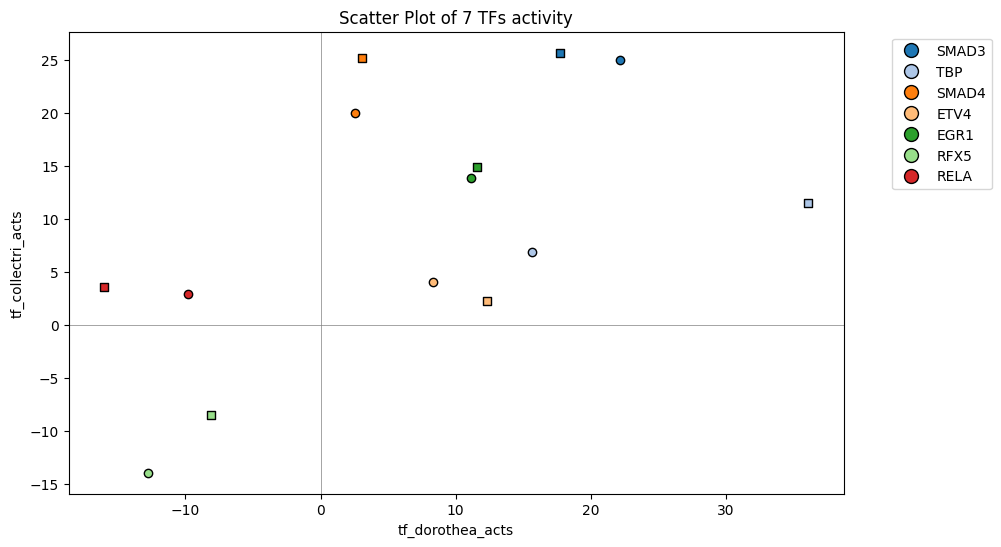

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Combine the 'tab20' and 'Set3' palettes
colors = sns.color_palette('tab20', 20) + sns.color_palette('Set3', 13)

matched_columns_filtered_selected = ['SMAD3','TBP','SMAD4','ETV4','EGR1','RFX5','RELA']

for i, col in enumerate(matched_columns_filtered_selected):
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean.iloc[[0]],
                    color=colors[i],
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)
    sns.scatterplot(x=f"{col}_dorothea",
                    y=f"{col}_collectri",
                    data=df_merged_filtered_mean.iloc[[1]],
                    color=colors[i],
                    marker='s',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1)


# plot horizontal line at y=0
plt.axhline(0, color='gray', linewidth=0.5)

# plot vertical line at x=0
plt.axvline(0, color='gray', linewidth=0.5)

# Custom legend
legend_labels = [plt.Line2D([0], [0],
                            marker='o',
                            color='w',
                            label=col,
                            markersize=10,
                            markerfacecolor=colors[i],
                            markeredgecolor='black',
                            linewidth=1) for i, col in enumerate(matched_columns_filtered_selected)]
plt.legend(handles=legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlabel('tf_dorothea_acts')
plt.ylabel('tf_collectri_acts')
plt.title(f'Scatter Plot of {len(matched_columns_filtered_selected)} TFs activity')
plt.show()

In [ ]:
# Get raw TFs activity score of the selected TFs
matched_columns_filtered_selected = ['SMAD3','TBP','SMAD4','ETV4','EGR1','RFX5','RELA']

# Filter columns
collectri_columns = [f"{col}_collectri" for col in matched_columns_filtered_selected] # matched_columns_filtered_selected
dorothea_columns = [f"{col}_dorothea" for col in matched_columns_filtered_selected] # matched_columns_filtered_selected

collectri_df = df_merged_filtered_mean[collectri_columns].T
collectri_df.index = matched_columns_filtered_selected

dorothea_df = df_merged_filtered_mean[dorothea_columns].T
dorothea_df.index = matched_columns_filtered_selected

# Re-arrange the column index to multi-level index
collectri_df.columns = pd.MultiIndex.from_product([['collectri'], collectri_df.columns], names=["Source", "Condition"])
dorothea_df.columns = pd.MultiIndex.from_product([['dorothea'], dorothea_df.columns], names=["Source", "Condition"])

# Add "difference" column
collectri_df[('collectri', 'difference')] = collectri_df[('collectri', 'treatment')] - collectri_df[('collectri', 'control')]
dorothea_df[('dorothea', 'difference')] = dorothea_df[('dorothea', 'treatment')] - dorothea_df[('dorothea', 'control')]

df_merged_filtered_selected = pd.concat([collectri_df, dorothea_df], axis=1)
df_merged_filtered_selected

Source     collectri                         dorothea                      
Condition    control  treatment difference    control  treatment difference
SMAD3      25.028122  25.687714   0.659592  22.138002  17.730715  -4.407288
TBP         6.824885  11.469475   4.644590  15.678473  36.112732  20.434258
SMAD4      19.946287  25.204620   5.258333   2.581891   3.066614   0.484724
ETV4        4.055309   2.257694  -1.797615   8.333816  12.352183   4.018368
EGR1       13.848778  14.923134   1.074356  11.117267  11.577641   0.460375
RFX5      -13.953298  -8.533314   5.419984 -12.789853  -8.081338   4.708515
RELA        2.887418   3.598069   0.710651  -9.824946 -16.039722  -6.214776

In [ ]:
# Get list of selected TFs in collectri
filtered_collectri_df = collectri.loc[collectri.source.isin(matched_columns_filtered_selected)]
filtered_collectri_df.target = filtered_collectri_df.target.str.upper()

print("Number of regulons:",filtered_collectri_df.target.unique().shape[0])

filtered_collectri_df
filtered_collectri_df[['source','weight']].groupby("source").count().rename(columns={'weight':'count'})

Number of regulons: 1077


count
source       
EGR1      360
ETV4       68
RELA      562
RFX5       26
SMAD3     190
SMAD4     142
TBP       167

In [ ]:
# Get list of selected TFs in dorothea
filtered_dorothea_df = dorothea.loc[dorothea.source.isin(matched_columns_filtered_selected)]
filtered_dorothea_df.target = filtered_dorothea_df.target.str.upper()

print("Number of regulons:",filtered_dorothea_df.target.unique().shape[0])

filtered_dorothea_df
filtered_dorothea_df[['source','weight']].groupby("source").count().rename(columns={'weight':'count'})

Number of regulons: 1415


count
source       
EGR1     1001
ETV4       60
RELA      243
RFX5       91
SMAD3      95
SMAD4      77
TBP        46

In [ ]:
mat_genes = mat.columns.to_list()
print("Number of input genes:",len(mat_genes))

Number of input genes: 17575


In [ ]:
# Get list of regulons on each TFs in collectri
filtered_collectri_df_available = filtered_collectri_df.loc[filtered_collectri_df.target.isin(mat_genes)]

print("Number of regulons:",filtered_collectri_df_available.target.unique().shape[0])

filtered_collectri_df_available
filtered_collectri_df_available[['source','weight']].groupby("source").count().rename(columns={'weight':'count'})

Number of regulons: 673


count
source       
EGR1      242
ETV4       44
RELA      333
RFX5       12
SMAD3     126
SMAD4      86
TBP       116

In [ ]:
# Get list of regulons on each TFs in dorothea
filtered_dorothea_df_available = filtered_dorothea_df.loc[filtered_dorothea_df.target.isin(mat_genes)]

print("Number of regulons:",filtered_dorothea_df_available.target.unique().shape[0])

filtered_dorothea_df_available
filtered_dorothea_df_available[['source','weight']].groupby("source").count().rename(columns={'weight':'count'})

Number of regulons: 1116


count
source       
EGR1      808
ETV4       48
RELA      179
RFX5       75
SMAD3      81
SMAD4      63
TBP        41

In [ ]:
# Filter list of regulons between collectri and dorothea
overlap_df = pd.merge(filtered_collectri_df_available, filtered_dorothea_df_available, on=['source', 'target'], how='inner')
overlap_counts = overlap_df.groupby('source')['target'].count()
overlap_counts

source
EGR1      95
ETV4      11
RELA     110
RFX5       4
SMAD3     28
SMAD4     25
TBP        6
Name: target, dtype: int64

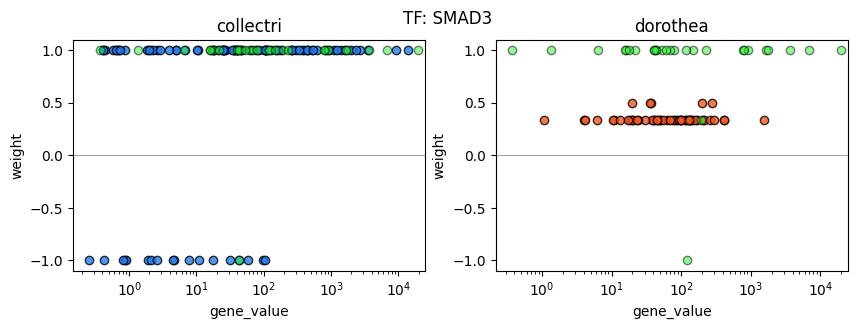

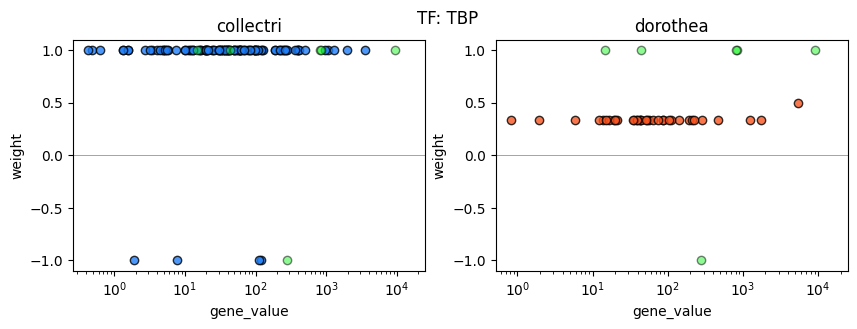

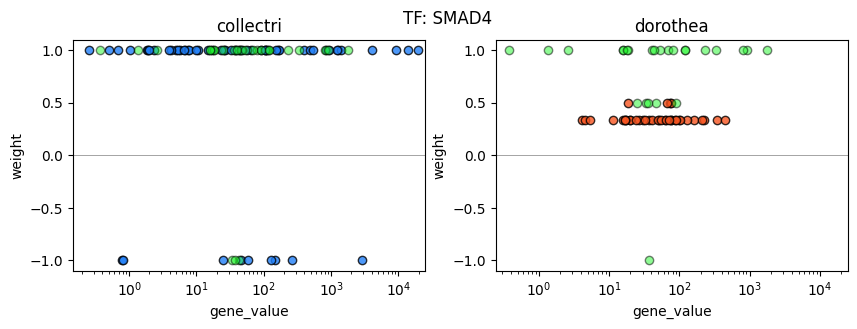

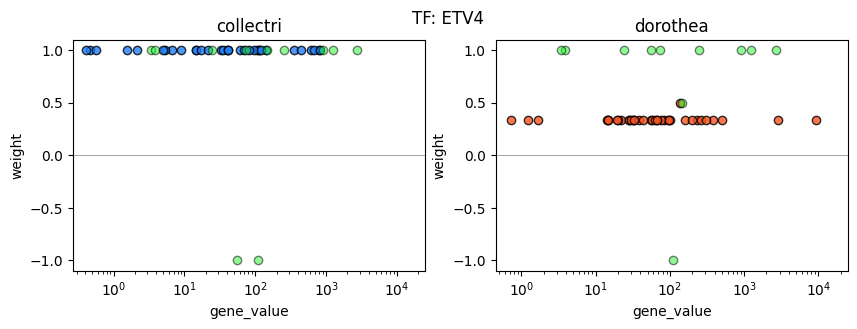

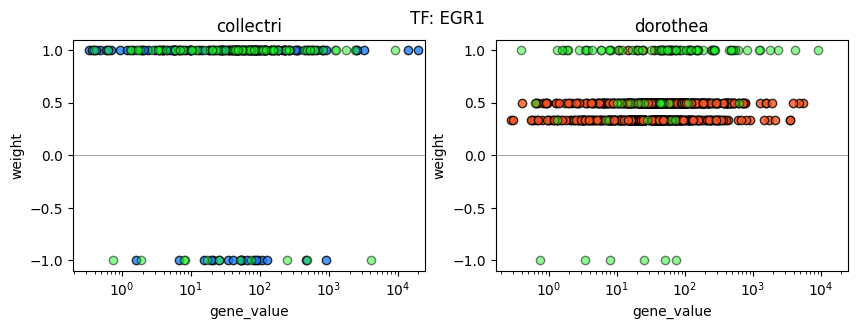

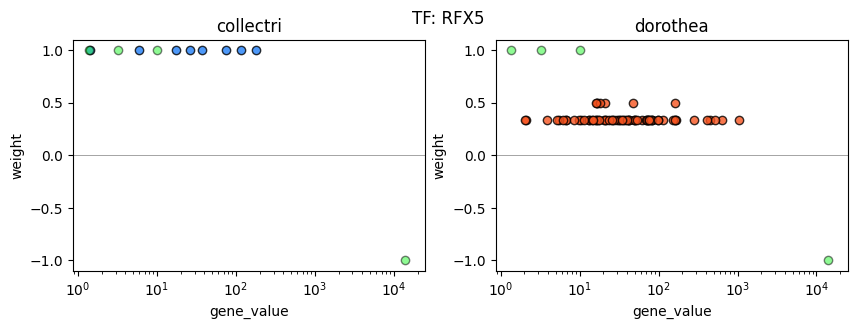

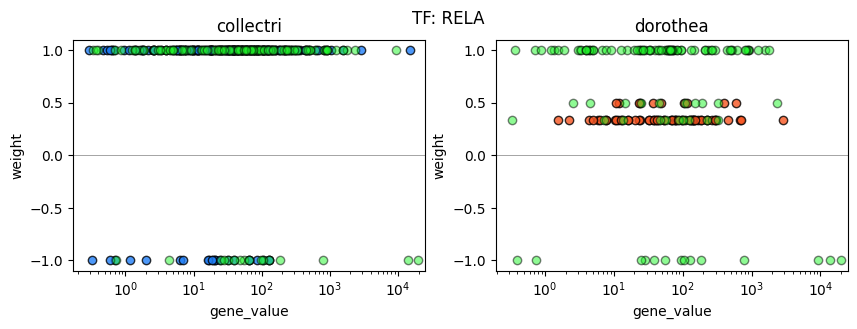

In [ ]:
# Select 'SMAD3'

def plot_tval_individual(select_tf):
    # select_tf = 'SMAD3'
    select_filtered_collectri = filtered_collectri_df_available.loc[ filtered_collectri_df_available.source == select_tf ]
    select_filtered_dorothea = filtered_dorothea_df_available.loc[ filtered_dorothea_df_available.source == select_tf ]

    # Get list of regulons
    select_mat_columns = pd.concat([select_filtered_collectri.target, select_filtered_dorothea.target]).drop_duplicates().to_list()
    select_mat = pd.DataFrame(mat[select_mat_columns].iloc[0:3,:].T.mean(axis=1)).rename(columns={0:'gene_value'})

    select_mat_collectri = pd.merge(select_filtered_collectri, select_mat, left_on='target', right_on='GeneName', how='inner')
    select_mat_dorothea = pd.merge(select_filtered_dorothea, select_mat, left_on='target', right_on='GeneName', how='inner')

    select_overlap = select_mat_collectri.loc[select_mat_collectri.target.isin(select_mat_dorothea.target)]['target'].to_list()
    select_mat_collectri_overlap = select_mat_collectri.loc[ select_mat_collectri.target.isin(select_overlap) ]
    select_mat_dorothea_overlap = select_mat_dorothea.loc[ select_mat_dorothea.target.isin(select_overlap) ]

    select_mat_collectri = select_mat_collectri.loc[~select_mat_collectri.target.isin(select_overlap)]
    select_mat_dorothea = select_mat_dorothea.loc[~select_mat_dorothea.target.isin(select_overlap)]

    # Create a scatter plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f'TF: {select_tf}')

    # Combine the 'tab20' and 'Set3' palettes
    colors = sns.color_palette(None, 4)

    axes[0].set_title('collectri')
    sns.scatterplot(ax=axes[0],
                    x="gene_value",
                    y="weight",
                    data=select_mat_collectri,
                    color="#217FF7",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    alpha=0.8)
    sns.scatterplot(ax=axes[0],
                    x="gene_value",
                    y="weight",
                    data=select_mat_collectri_overlap,
                    color="#21f72b",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    alpha=0.5)

    axes[0].set_xscale('log')
    axes[0].set_xlim([-1e3,2.5e4])

    axes[1].set_title('dorothea')
    sns.scatterplot(ax=axes[1],
                    x="gene_value",
                    y="weight",
                    data=select_mat_dorothea,
                    color="#f75521",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    alpha=0.8)
    sns.scatterplot(ax=axes[1],
                    x="gene_value",
                    y="weight",
                    data=select_mat_dorothea_overlap,
                    color="#21f72b",
                    marker='o',
                    legend=False,
                    edgecolor="black",
                    linewidth = 1,
                    alpha=0.5)

    axes[1].set_xscale('log')
    axes[1].set_xlim([-1e3,2.5e4])

    # plot horizontal line at y=0
    axes[0].axhline(0, color='gray', linewidth=0.5)
    axes[0].axvline(0, color='gray', linewidth=0.5)

    # plot vertical line at x=0
    axes[1].axvline(0, color='gray', linewidth=0.5)
    axes[1].axhline(0, color='gray', linewidth=0.5)

# plot_tval_individual('SMAD3')
for col in matched_columns_filtered_selected:
    plot_tval_individual(col)

In [ ]:
# Calculate TF activity score for each TF
def mat_cov(A, b):
    return np.dot(b.T - b.mean(), A - A.mean(axis=0)) / (b.shape[0]-1)

def mat_cor(A, b):
    cov = mat_cov(A, b)
    ssd = np.std(A, axis=0, ddof=1) * np.std(b, axis=0, ddof=1).reshape(-1, 1)
    return cov / ssd

def t_val(r, df):
    return r * np.sqrt(df / ((1.0 - r + 1.0e-16)*(1.0 + r + 1.0e-16)))

select_tf = 'SMAD3'
select_filtered_collectri = filtered_collectri_df_available.loc[ filtered_collectri_df_available.source == select_tf ]
select_filtered_dorothea = filtered_dorothea_df_available.loc[ filtered_dorothea_df_available.source == select_tf ]

# Get list of regulons
select_mat_columns = pd.concat([select_filtered_collectri.target, select_filtered_dorothea.target]).drop_duplicates().to_list()
select_mat = pd.DataFrame(mat[select_mat_columns].iloc[0:3,:].T.mean(axis=1)).rename(columns={0:'gene_value'})

select_mat_collectri = pd.merge(select_filtered_collectri, select_mat, left_on='target', right_on='GeneName', how='inner')
select_mat_dorothea = pd.merge(select_filtered_dorothea, select_mat, left_on='target', right_on='GeneName', how='inner')

r = mat_cor(select_mat_collectri.weight, select_mat_collectri.gene_value)
es = t_val(r, select_mat_collectri.shape[0] - 2)
print("T-value of Slope:", es)


T-value of Slope: [[1.3085555]]


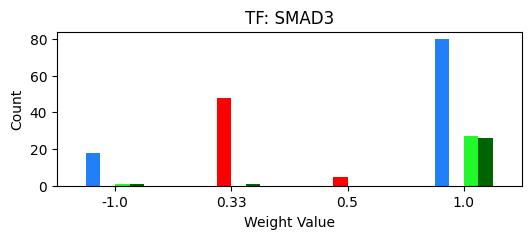

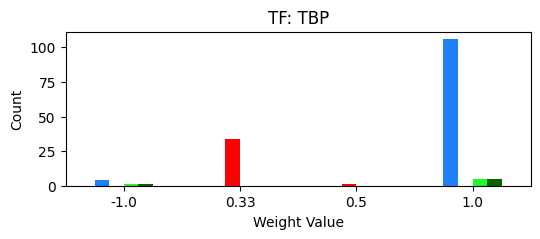

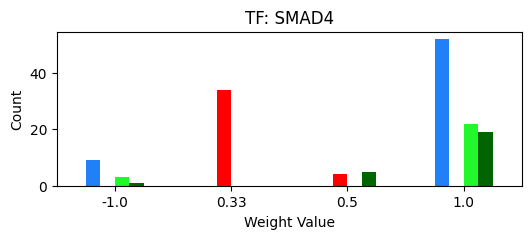

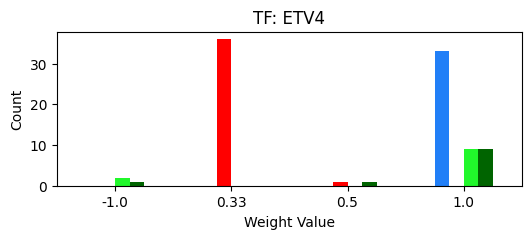

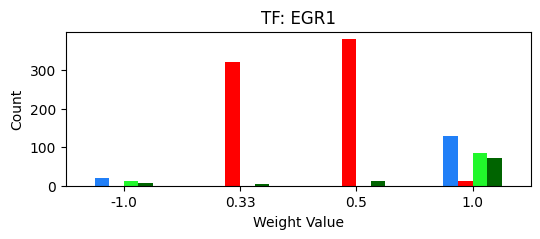

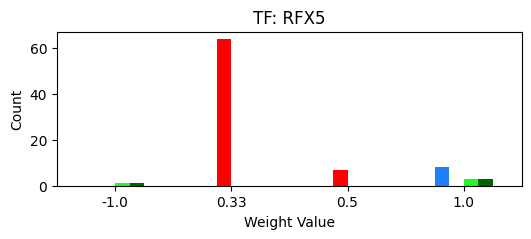

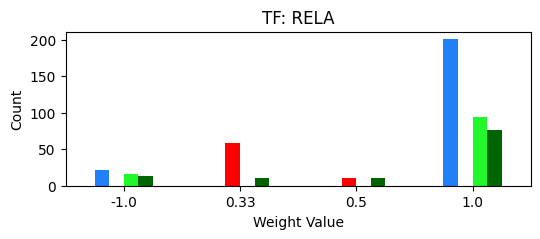

In [ ]:
# Select 'SMAD3'

def plot_count_regulons(select_tf):
    # select_tf = 'SMAD3'
    select_filtered_collectri = filtered_collectri_df_available.loc[ filtered_collectri_df_available.source == select_tf ]
    select_filtered_dorothea = filtered_dorothea_df_available.loc[ filtered_dorothea_df_available.source == select_tf ]

    # Get list of regulons
    select_mat_columns = pd.concat([select_filtered_collectri.target, select_filtered_dorothea.target]).drop_duplicates().to_list()
    select_mat = pd.DataFrame(mat[select_mat_columns].iloc[0:3,:].T.mean(axis=1)).rename(columns={0:'gene_value'})

    select_mat_collectri = pd.merge(select_filtered_collectri, select_mat, left_on='target', right_on='GeneName', how='inner')
    select_mat_dorothea = pd.merge(select_filtered_dorothea, select_mat, left_on='target', right_on='GeneName', how='inner')

    select_overlap = select_mat_collectri.loc[select_mat_collectri.target.isin(select_mat_dorothea.target)]['target'].to_list()
    select_mat_collectri_overlap = select_mat_collectri.loc[ select_mat_collectri.target.isin(select_overlap) ]
    select_mat_dorothea_overlap = select_mat_dorothea.loc[ select_mat_dorothea.target.isin(select_overlap) ]

    select_mat_collectri = select_mat_collectri.loc[~select_mat_collectri.target.isin(select_overlap)]
    select_mat_dorothea = select_mat_dorothea.loc[~select_mat_dorothea.target.isin(select_overlap)]


    # pd.merge(select_mat_collectri_overlap,select_mat_dorothea_overlap,on='target')

    # Create a DataFrame with the counts
    counts_df = pd.DataFrame({
        'collectri': select_mat_collectri['weight'].value_counts(),
        'dorothea': select_mat_dorothea['weight'].value_counts(),
        'collectri_overlap': select_mat_collectri_overlap['weight'].value_counts(),
        'dorothea_overlap': select_mat_dorothea_overlap['weight'].value_counts(),
    })

    # Fill NaN values with 0
    counts_df = counts_df.fillna(0)
    counts_df.index = counts_df.index.to_series().round(2).astype(str)

    # Plot the DataFrame
    colors = ['#217FF7', 'red', '#21f72b', 'darkgreen']
    ax = counts_df.plot(kind='bar', figsize=(6, 2), color=colors)
    plt.xticks(rotation=0)
    plt.xlabel('Weight Value')
    plt.ylabel('Count')
    plt.title(f'TF: {select_tf}')
    plt.legend().set_visible(False)
    plt.show()

# plot_count_regulons('SMAD3')
for col in matched_columns_filtered_selected:
    plot_count_regulons(col)

In [ ]:
# Merge two dataframe tables and rename the row names

df_wodea = pd.concat([
    tf_collectri_acts.iloc[0:3,],
    tf_dorothea_acts.iloc[0:3,],
    tf_collectri_acts.iloc[3:6,],
    tf_dorothea_acts.iloc[3:6,]
], axis=0, join='inner', sort=False)

df_wodea.index = ['control_25_collectri',
'control_26_collectri',
'control_27_collectri',
'control_25_dorothea',
'control_26_dorothea',
'control_27_dorothea',
'treatment_31_collectri',
'treatment_32_collectri',
'treatment_33_collectri',
'treatment_31_dorothea',
'treatment_32_dorothea',
'treatment_33_dorothea']

df_wodea

AHR        AR    ARID3A      ARNT     ASCL1  \
control_25_collectri    3.513768  7.374182  0.792456  1.198286  2.654510   
control_26_collectri    3.439764  7.277483  0.805713  1.125570  2.602200   
control_27_collectri    3.423932  7.011393  0.803646  1.120977  2.618362   
control_25_dorothea     1.021086  3.672184  0.081744  2.697176  0.406037   
control_26_dorothea     0.837120  3.125765  0.059671  2.484155  0.425281   
control_27_dorothea     0.733425  3.235074  0.039755  2.302288  0.379323   
treatment_31_collectri  2.637449  8.492096  0.297469  1.458125  1.839883   
treatment_32_collectri  2.539009  8.553974  0.306204  1.344882  1.748260   
treatment_33_collectri  2.437673  8.715354  0.262756  1.456021  1.636797   
treatment_31_dorothea   0.146720  1.907997  0.030676  1.489435  0.167627   
treatment_32_dorothea   0.142365  1.933520  0.066514  1.523887  0.155074   
treatment_33_dorothea   0.148002  1.912735  0.049040  1.451231  0.150502   

                            ATF1       ATF2       ATF3      ATF4      ATF6  \
control_25_collectri    2.785471   6.056330   5.635913  3.636624  2.615047   
control_26_collectri    2.350424   6.752047   6.186154  3.380385  2.349293   
control_27_collectri    2.621725   6.114440   5.627210  3.414000  2.376799   
control_25_dorothea     1.640476   9.651978   0.612117  1.249952  4.558881   
control_26_dorothea     1.518833  11.370803   0.600986  1.228788  4.129539   
control_27_dorothea     1.453785   9.988415   0.632513  1.174859  4.124165   
treatment_31_collectri -0.137174  12.579825  13.259231  1.412705  1.391680   
treatment_32_collectri -0.229812  12.704719  13.202457  1.277132  1.351969   
treatment_33_collectri -0.143629  13.176441  14.049950  1.349135  1.276085   
treatment_31_dorothea   0.882310  24.084148   0.323295  0.646517  2.472003   
treatment_32_dorothea   0.908797  24.430395   0.302602  0.680592  2.430310   
treatment_33_dorothea   0.834315  25.430475   0.284248  0.620383  2.287618   

                        ...       YY1     ZBED1    ZBTB33    ZBTB7A  \
control_25_collectri    ...  8.715239  2.381996 -1.141674 -1.290222   
control_26_collectri    ...  9.215903  2.082944 -1.217136 -1.271940   
control_27_collectri    ...  9.471114  2.486660 -1.369599 -1.328834   
control_25_dorothea     ...  0.120190  0.830525  1.316495  3.326636   
control_26_dorothea     ...  0.217628  0.697476  1.146904  3.190058   
control_27_dorothea     ...  0.147464  0.715901  1.008755  3.540641   
treatment_31_collectri  ...  6.307020  0.939028 -0.417848 -0.290940   
treatment_32_collectri  ...  6.155406  0.714664 -0.352143 -0.208509   
treatment_33_collectri  ...  5.731775  0.822638 -0.403469 -0.211865   
treatment_31_dorothea   ...  0.387686  0.173485  0.386527  1.383568   
treatment_32_dorothea   ...  0.391979  0.165230  0.429917  1.166487   
treatment_33_dorothea   ...  0.372879  0.147714  0.397987  1.039810   

                             ZEB1       ZEB2      ZHX2    ZNF143    ZNF263  \
control_25_collectri   -12.120121  -2.908425  0.385789  0.089191  0.301880   
control_26_collectri   -12.485945  -1.751704  0.340867  0.073348  0.484727   
control_27_collectri   -13.637736  -2.820415  0.338897  0.069136  0.361005   
control_25_dorothea      7.565924   5.333564  1.066102  0.994266  2.313812   
control_26_dorothea      7.463633   5.112087  0.990801  1.010280  2.313849   
control_27_dorothea      7.073108   5.214593  1.036648  1.007952  2.391270   
treatment_31_collectri   0.344045  16.448116  0.164784 -0.059671  0.085553   
treatment_32_collectri   0.914211  16.542549  0.159936 -0.077539  0.080793   
treatment_33_collectri   2.678041  17.678442  0.156299 -0.080893  0.084433   
treatment_31_dorothea    5.270473   2.422393  0.286207  0.401297  0.951346   
treatment_32_dorothea    5.183165   2.139276  0.290495  0.342633  0.818233   
treatment_33_dorothea    5.175720   2.219488  0.273864  0.341225  0.814429   

                           ZNF384  
control_25_collectri    17.152018  
control_26_col

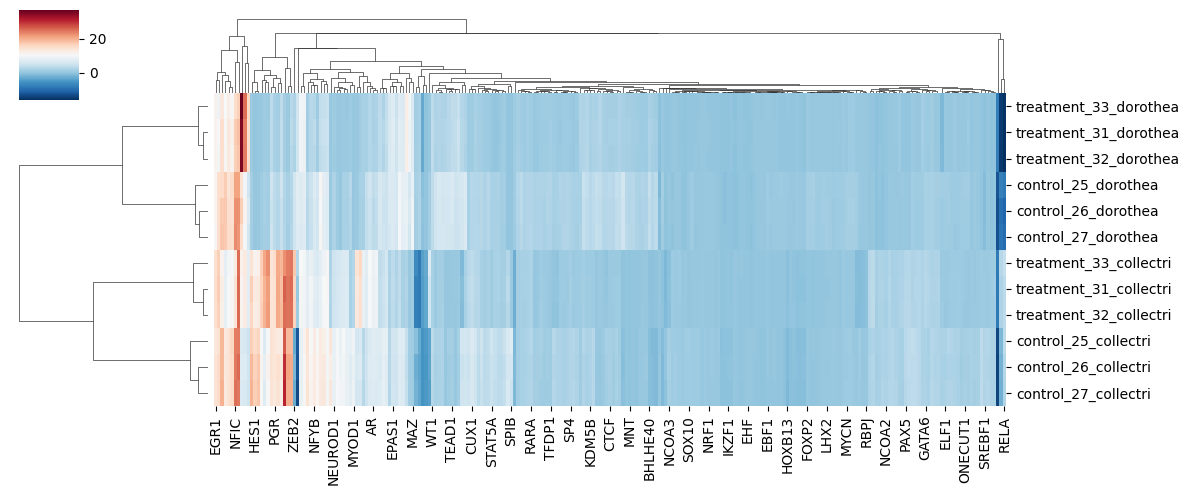

In [ ]:
# Convert dataframe to anndata object
adata_wodea = sc.AnnData(df_wodea)

# Plot clustermap
sc.pl.clustermap(adata_wodea, cmap="RdBu_r", figsize=(12,5))

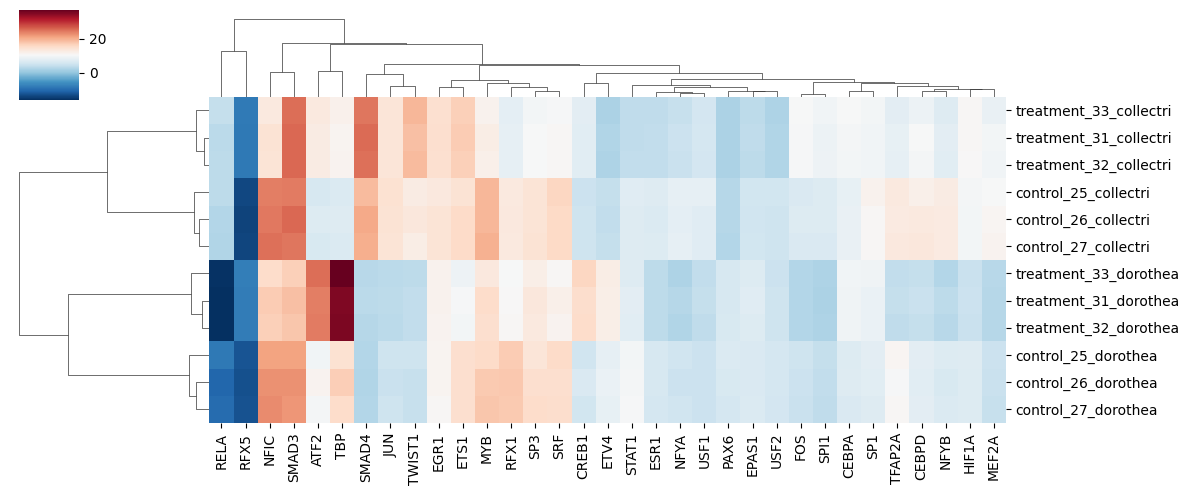

In [ ]:
# Plot clustermap of overlap 33 TFs
df_wodea_overlap = df_wodea[matched_columns_filtered]
adata_wodea_overlap = sc.AnnData(df_wodea_overlap)

# Plot clustermap
sc.pl.clustermap(adata_wodea_overlap, cmap="RdBu_r", figsize=(12,5))

### **TASK 2** With DEA

In [ ]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=adata_filtered,
    design_factors='condition',
    refit_cooks=True,
    n_cpus=8,
)
dds

AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    obsm: 'design_matrix'
    layers: 'counts'

In [ ]:
# Compute LFCs
dds.deseq2()
dds

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 217.05 seconds.

Fitting dispersion trend curve...
... done in 8.38 seconds.

Fitting MAP dispersions...
... done in 215.03 seconds.

Fitting LFCs...
... done in 13.95 seconds.

Refitting 0 outliers.



AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors'
    varm: 'non_zero', '_rough_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'counts', 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [ ]:
# Extract contrast between treatment vs normal
stat_res = DeseqStats(dds, contrast=["condition", 'treatment', 'control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 4.51 seconds.



Log2 fold change & Wald test p-value: condition treatment vs control


baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneName                                                                   
RP11-34P13.7     45.820190        0.067094  0.294257  0.228010  0.819639   
RP11-34P13.8     29.560568       -0.086227  0.249617 -0.345438  0.729765   
CICP27          106.257057        0.144798  0.177248  0.816925  0.413971   
FO538757.2       33.114796       -0.634443  0.286075 -2.217747  0.026572   
AP006222.2       67.154701        0.579098  0.270626  2.139848  0.032367   
...                    ...             ...       ...       ...       ...   
MT-ND6        17962.507812       -0.445816  0.278378 -1.601475  0.109272   
MT-TE          1284.633179       -0.343227  0.287943 -1.191996  0.233263   
MT-CYB        55097.121094       -0.323882  0.302438 -1.070903  0.284213   
MT-TT           205.288528       -0.495090  0.332233 -1.490190  0.136174   
MT-TP           346.101318       -0.473558  0.200422 -2.362806  0.018137   

                  padj  
GeneName                
RP11-34P13.7  0.871654  
RP11-34P13.8  0.801351  
CICP27        0.521994  
FO538757.2    0.050794  
AP006222.2    0.060587  
...                ...  
MT-ND6        0.175000  
MT-TE         0.330373  
MT-CYB        0.387995  
MT-TT         0.210545  
MT-TP         0.036124  

[17575 rows x 6 columns]

In [ ]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='condition_treatment_vs_control')

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition treatment vs control


... done in 30.00 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneName                                                                   
RP11-34P13.7     45.820190        0.050407  0.271447  0.228010  0.819639   
RP11-34P13.8     29.560568       -0.068949  0.234608 -0.345438  0.729765   
CICP27          106.257057        0.129368  0.172303  0.816925  0.413971   
FO538757.2       33.114796       -0.523892  0.280505 -2.217747  0.026572   
AP006222.2       67.154701        0.483006  0.266258  2.139848  0.032367   
...                    ...             ...       ...       ...       ...   
MT-ND6        17962.507812       -0.240886  0.260519 -1.601475  0.109272   
MT-TE          1284.633179       -0.265368  0.273098 -1.191996  0.233263   
MT-CYB        55097.121094       -0.523154  0.297741 -1.070903  0.284213   
MT-TT           205.288528       -0.366886  0.316293 -1.490190  0.136174   
MT-TP           346.101318       -0.424278  0.197644 -2.362806  0.018137   

                  padj  
GeneName                
RP11-34P13.7  0.871654  
RP11-34P13.8  0.801351  
CICP27        0.521994  
FO538757.2    0.050794  
AP006222.2    0.060587  
...                ...  
MT-ND6        0.175000  
MT-TE         0.330373  
MT-CYB        0.387995  
MT-TT         0.210545  
MT-TP         0.036124  

[17575 rows x 6 columns]

In [ ]:
# Extract results
results_df = stat_res.results_df
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneName                                                                   
RP11-34P13.7     45.820190        0.050407  0.271447  0.228010  0.819639   
RP11-34P13.8     29.560568       -0.068949  0.234608 -0.345438  0.729765   
CICP27          106.257057        0.129368  0.172303  0.816925  0.413971   
FO538757.2       33.114796       -0.523892  0.280505 -2.217747  0.026572   
AP006222.2       67.154701        0.483006  0.266258  2.139848  0.032367   
...                    ...             ...       ...       ...       ...   
MT-ND6        17962.507812       -0.240886  0.260519 -1.601475  0.109272   
MT-TE          1284.633179       -0.265368  0.273098 -1.191996  0.233263   
MT-CYB        55097.121094       -0.523154  0.297741 -1.070903  0.284213   
MT-TT           205.288528       -0.366886  0.316293 -1.490190  0.136174   
MT-TP           346.101318       -0.424278  0.197644 -2.362806  0.018137   

                  padj  
GeneName                
RP11-34P13.7  0.871654  
RP11-34P13.8  0.801351  
CICP27        0.521994  
FO538757.2    0.050794  
AP006222.2    0.060587  
...                ...  
MT-ND6        0.175000  
MT-TE         0.330373  
MT-CYB        0.387995  
MT-TT         0.210545  
MT-TP         0.036124  

[17575 rows x 6 columns]

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


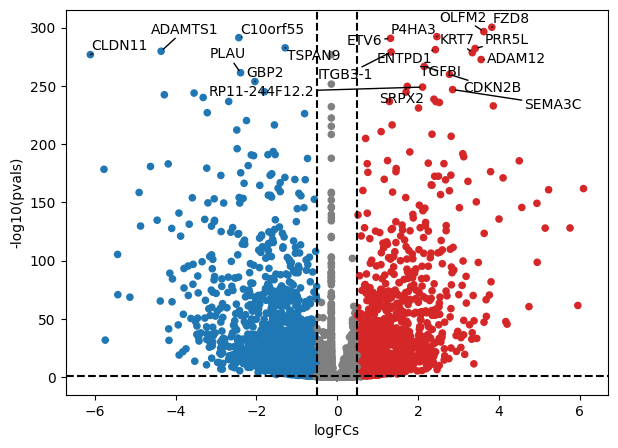

In [ ]:
# Show Vocano Plot
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

In [ ]:
# Obtain gene level statistics to perform enrichment analysis
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName              RP11-34P13.7  RP11-34P13.8    CICP27  FO538757.2  \
treatment.vs.control       0.22801     -0.345438  0.816925   -2.217747   

GeneName              AP006222.2  RP4-669L17.10  MTND1P23  MTND2P28  \
treatment.vs.control    2.139848      -0.422515 -1.373661  -0.53866   

GeneName              AC114498.1   MIR6723  ...    MT-ND4     MT-TH    MT-TS2  \
treatment.vs.control   -2.845663 -3.862065  ... -1.472827  0.550156  0.704443   

GeneName                MT-TL2    MT-ND5    MT-ND6     MT-TE    MT-CYB  \
treatment.vs.control  1.049607 -1.283784 -1.601475 -1.191996 -1.070903   

GeneName                MT-TT     MT-TP  
treatment.vs.control -1.49019 -2.362806  

[1 rows x 17575 columns]

CollecTRI network

In [ ]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 17575 targets for 629 sources.


ABL1       AHR      AIRE       AP1     APEX1  \
treatment.vs.control -1.757384 -2.041384 -1.317279 -2.718626 -2.338566   

                            AR    ARID1A    ARID3A   ARID3B    ARID4A  ...  \
treatment.vs.control  0.178862 -6.440889  1.410645  2.23343 -0.704304  ...   

                       ZNF354C    ZNF362    ZNF382   ZNF384    ZNF395  \
treatment.vs.control -1.164067 -0.933561  2.687689  1.49982 -1.249087   

                        ZNF436    ZNF699     ZNF76   ZNF804A    ZNF91  
treatment.vs.control -1.407577 -0.820753  0.485726  2.157699  0.86518  

[1 rows x 629 columns]

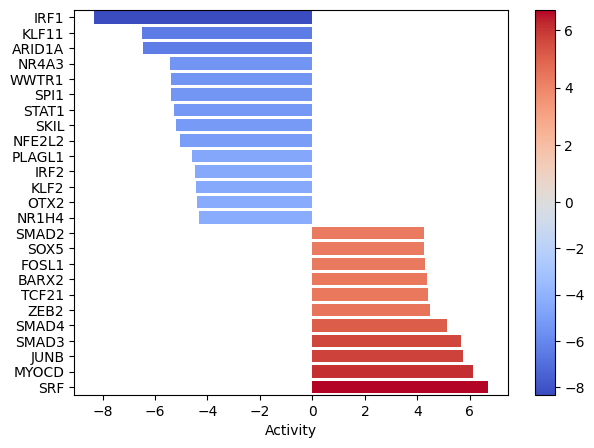

In [ ]:
# Show the obtained scores for the top active/inactive transcription factors
dc.plot_barplot(tf_acts, 'treatment.vs.control', top=25, vertical=True)

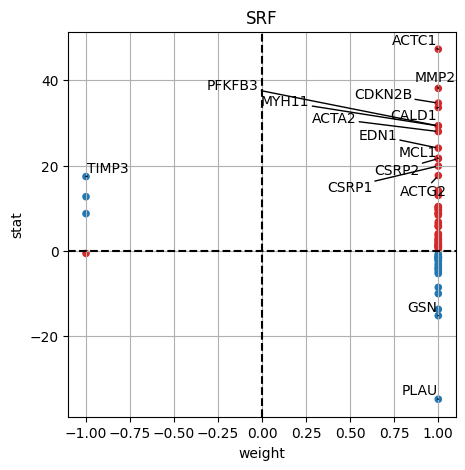

In [ ]:
# Manually inspect the downstream targets of each transcription factor
dc.plot_targets(results_df, stat='stat', source_name='SRF', net=collectri, top=15)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


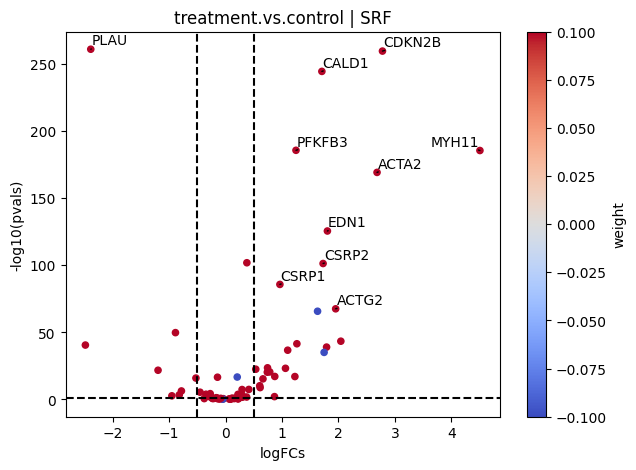

In [ ]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(logFCs, pvals, 'treatment.vs.control', name='SRF', net=collectri, top=10, sign_thr=0.05, lFCs_thr=0.5)